In [1]:
import sys
import os
sys.path.append(os.path.abspath("../src"))
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal
from modem import qpsk, chirp, wav, pilot, estimate, freq
from modem.constants import FS, DATA_BLOCK_LENGTH, BYTES_BLOCK_LENGTH, DATA_PER_PILOT, OFDM_SYMBOL_LENGTH

In [2]:
#TODO: Use an actual file here
TRANSMITTED_DATA_BLOCKS = 200
rng = np.random.default_rng(seed=42)
data_bytes = bytes(rng.integers(256, size=BYTES_BLOCK_LENGTH * TRANSMITTED_DATA_BLOCKS, dtype=np.uint8))
data_bits = np.unpackbits(np.frombuffer(data_bytes, dtype=np.uint8))
data_qpsk_values = qpsk.qpsk_encode(data_bits)
data_ofdm_symbols = qpsk.encode_ofdm_symbol(data_qpsk_values)

num_ofdm_blocks = data_ofdm_symbols.shape[0]
print(f"Data encoded into {num_ofdm_blocks} OFDM blocks")

rng = np.random.default_rng(seed=42)
pilot_bits = rng.integers(2, size=DATA_BLOCK_LENGTH * 2 * (num_ofdm_blocks + 1))
pilot_qpsk_symbols = qpsk.qpsk_encode(pilot_bits)
pilot_ofdm_symbols = qpsk.encode_ofdm_symbol(pilot_qpsk_symbols)

ofdm_symbols = pilot.interleave_pilot_blocks(data_ofdm_symbols,pilot_ofdm_symbols)
signal = np.concatenate((chirp.START_CHIRP, ofdm_symbols.flatten(), chirp.END_CHIRP))

Data encoded into 200 OFDM blocks


In [167]:
wav.generate_wav("pilots_H06.wav", signal)

Saved to C:\Users\dcies\Desktop\Audio Modem\audio_modem_2025\src\modem\..\..\files\pilots_H06.wav


In [14]:
wav.record_wav("2025-05-30_H06.wav", 100)

Recording for 100 seconds at 48000 Hz...
Saved to C:\Users\dcies\Desktop\Audio Modem\audio_modem_2025\src\modem\..\..\files\2025-05-30_H06.wav


In [15]:
recv_signal = wav.read_wav("2025-05-30_H06.wav")

start_lag = np.int64(3566828), end_lag = np.int64(830618), difference = np.int64(-2736210), expected_difference = 4154240


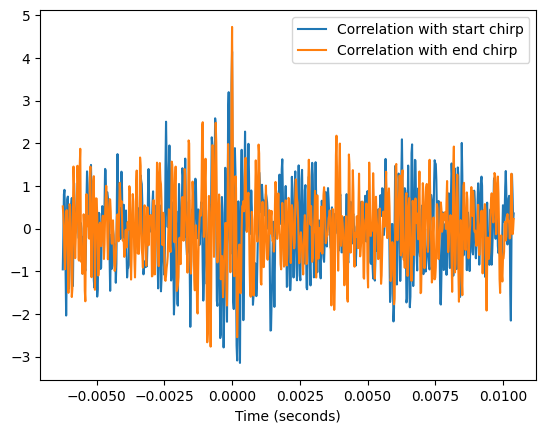

In [16]:
#TODO: Dont assume known length of stuff, repeated synchronisation etc
aligned_recv_signal = chirp.synchronise(recv_signal, sum(map(len, ofdm_symbols)), plot_correlations=True)
RECIEVED_BLOCKS = int(len(aligned_recv_signal[chirp.START_CHIRP.size:-chirp.END_CHIRP.size])/OFDM_SYMBOL_LENGTH)
recv_ofdm_symbols = np.reshape(aligned_recv_signal[chirp.START_CHIRP.size:-chirp.END_CHIRP.size], (RECIEVED_BLOCKS, -1))

In [17]:
RECIEVED_PILOT_BLOCKS = int(1+((RECIEVED_BLOCKS-1)//(1+DATA_PER_PILOT)))
RECIEVED_DATA_BLOCKS = RECIEVED_BLOCKS - RECIEVED_PILOT_BLOCKS

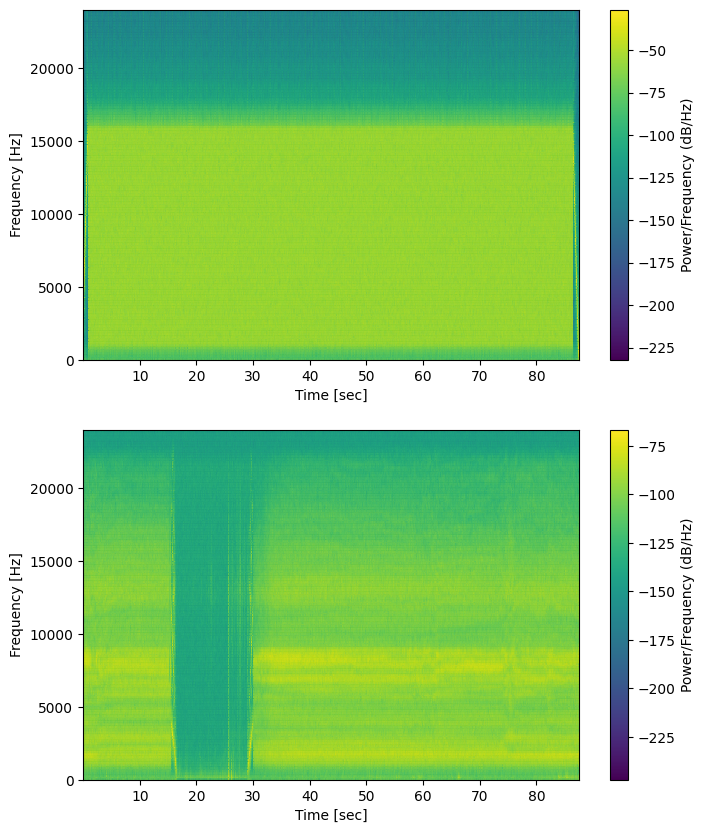

In [18]:
fig, axs = plt.subplots(2, figsize=(8, 10))
axs: tuple[plt.Axes]

for sig, ax in zip((signal, aligned_recv_signal), axs):
    f, t_spec, Sxx = scipy.signal.spectrogram(sig, FS)

    pcm = ax.pcolormesh(t_spec, f, 10 * np.log10(Sxx), shading='gouraud')
    ax.set_ylabel('Frequency [Hz]')
    ax.set_xlabel('Time [sec]')
    cbar = fig.colorbar(pcm, ax=ax, label='Power/Frequency (dB/Hz)')

In [19]:
data_qpsk_values = np.reshape(data_qpsk_values,[-1,DATA_BLOCK_LENGTH])
pilot_qpsk_symbols = np.reshape(pilot_qpsk_symbols,[-1,DATA_BLOCK_LENGTH])
known_qpsk_symbols = pilot.interleave_pilot_blocks(np.full((RECIEVED_DATA_BLOCKS, DATA_BLOCK_LENGTH), np.nan, dtype=np.complex128), pilot_qpsk_symbols)

C:\Users\dcies\AppData\Local\Temp\ipykernel_28636\981816907.py:1: RuntimeWarning: invalid value encountered in divide
  observed_freq_gains = qpsk.decode_ofdm_symbol(recv_ofdm_symbols)/known_qpsk_symbols


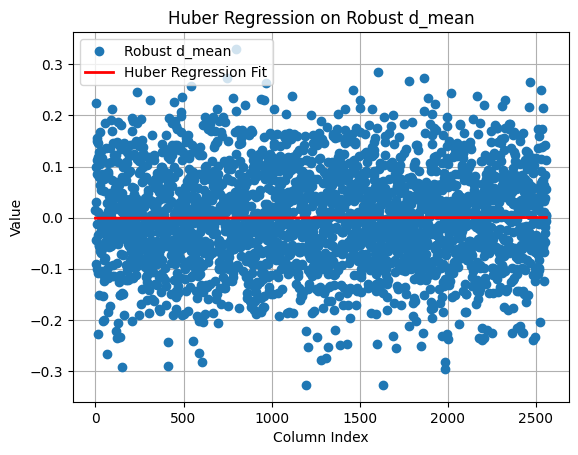

c:\Users\dcies\Desktop\Audio Modem\audio_modem_2025\src\modem\freq.py:67: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = plt.scatter(real_parts, imag_parts, c=colors, cmap=cmap, marker='o')


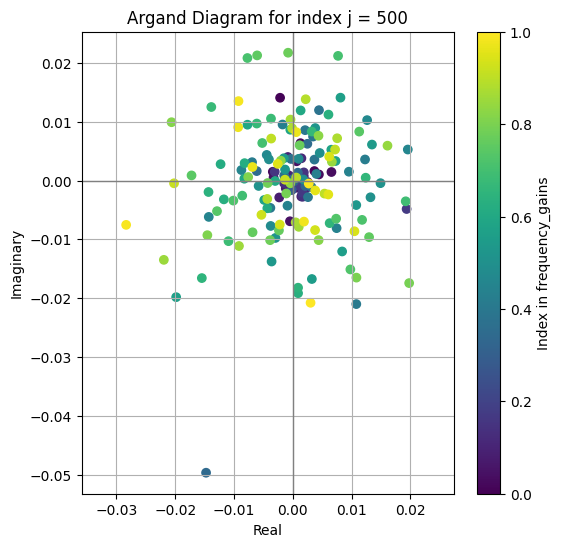

In [20]:
observed_freq_gains = qpsk.decode_ofdm_symbol(recv_ofdm_symbols)/known_qpsk_symbols
freq_gains = freq.get_freq_gains(observed_freq_gains)

In [21]:
snr_estimates = estimate.estimate_snr(known_qpsk_symbols, qpsk.decode_ofdm_symbol(recv_ofdm_symbols), freq_gains)
average_snr = np.nanmean(snr_estimates, axis=0)

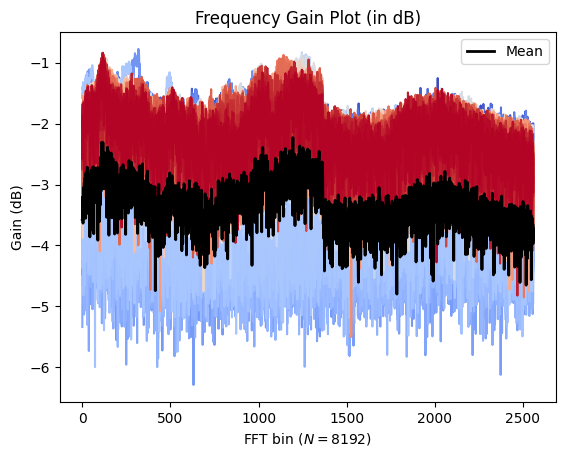

In [22]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# Filter out rows with NaNs
valid_blocks = observed_freq_gains[~np.isnan(observed_freq_gains).any(axis=1)]
n_blocks = len(valid_blocks)

# Create color map
colors = cm.coolwarm(np.linspace(0, 1, n_blocks))  # You can use other colormaps like 'plasma', 'inferno'

fig, ax = plt.subplots()
for i, (block_gain, color) in enumerate(zip(valid_blocks, colors)):
    ax.plot(np.log10(np.abs(block_gain)), color=color)

# Plot the mean in black
ax.plot(np.log10(np.abs(freq_gains[0])), color='black', label="Mean", linewidth=2)

ax.set_title('Frequency Gain Plot (in dB)')
ax.set_xlabel('FFT bin ($N = 8192$)')
ax.set_ylabel('Gain (dB)')
ax.legend()
plt.show()

In [ ]:
recv_data_ofdm_symbols, recv_pilot_ofdm_symbols = pilot.extract_pilot_blocks(recv_ofdm_symbols)
data_freq_gains, pilot_freq_gains = pilot.extract_pilot_blocks(freq_gains)

In [ ]:
# recv_qpsk_symbols = [qpsk.decode_ofdm_symbol(recv_sym[np.newaxis, :], avg_gain[np.newaxis, :], average_snr)[0] for recv_sym in recv_data_ofdm_symbols]
recv_qpsk_symbols = qpsk.wiener_filter(qpsk.decode_ofdm_symbol(recv_data_ofdm_symbols), data_freq_gains, average_snr)

C:\Users\dcies\AppData\Local\Temp\ipykernel_28636\3752314967.py:11: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots()


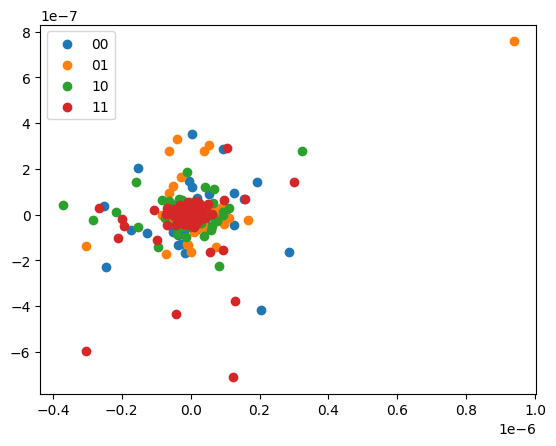

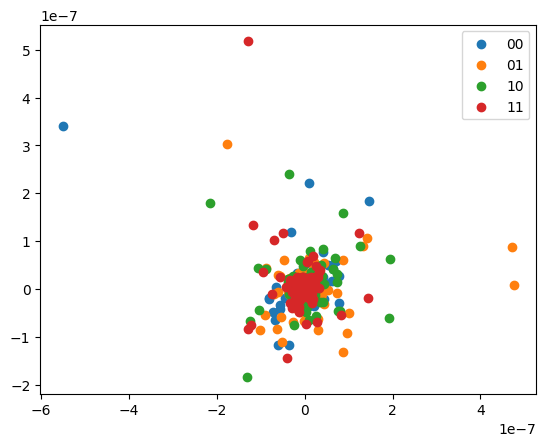

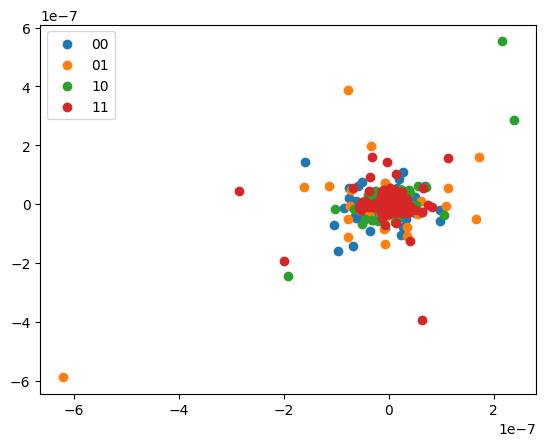

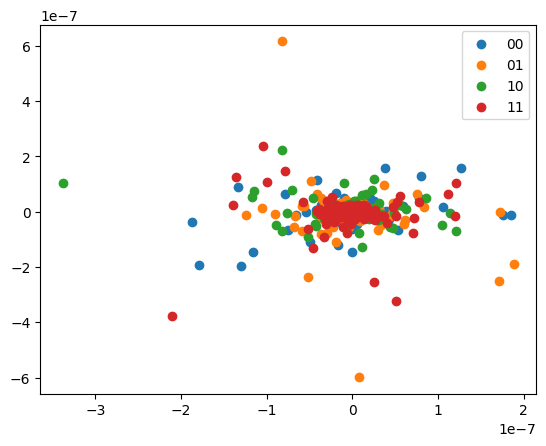

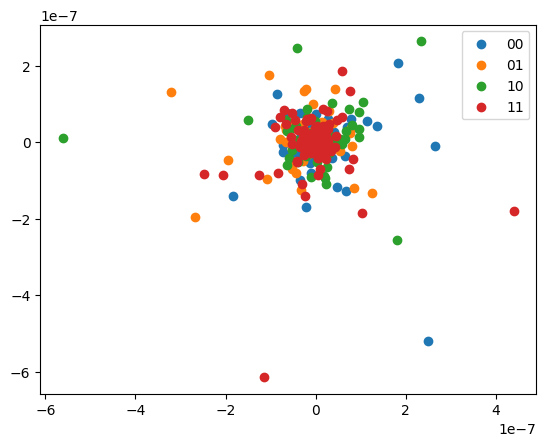

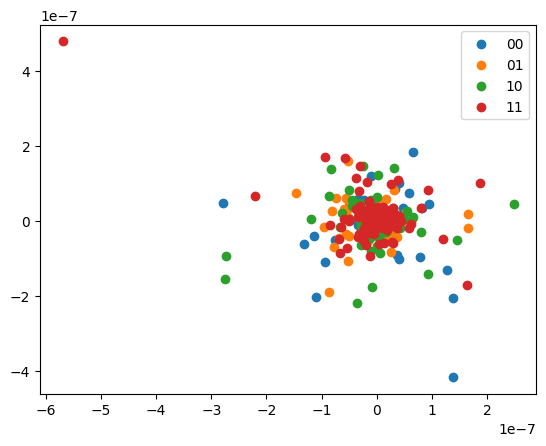

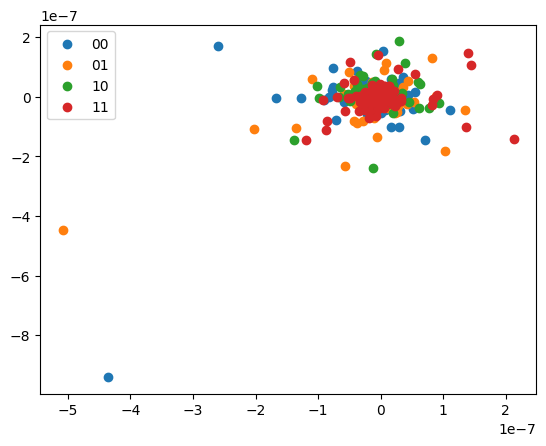

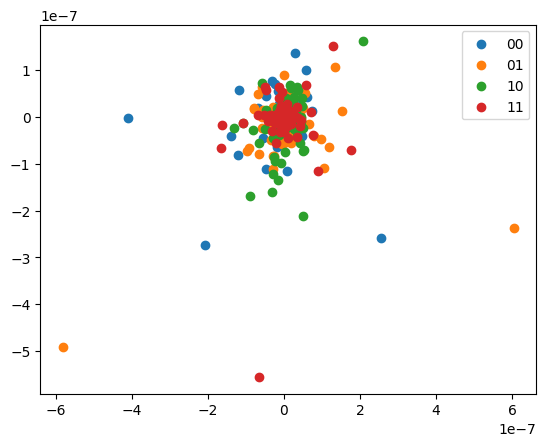

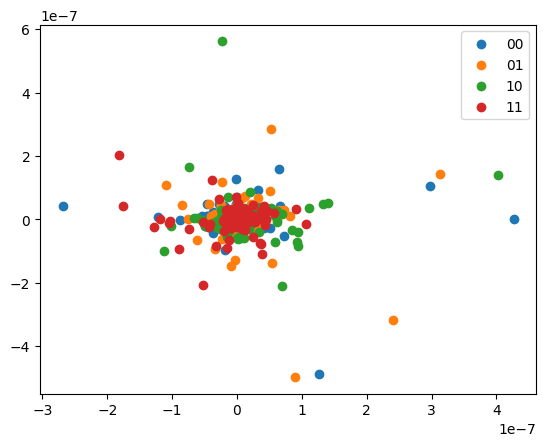

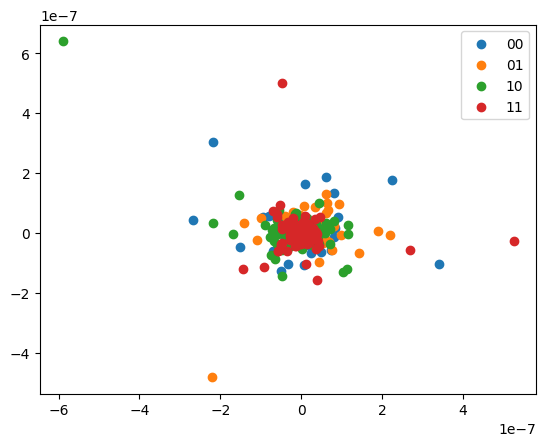

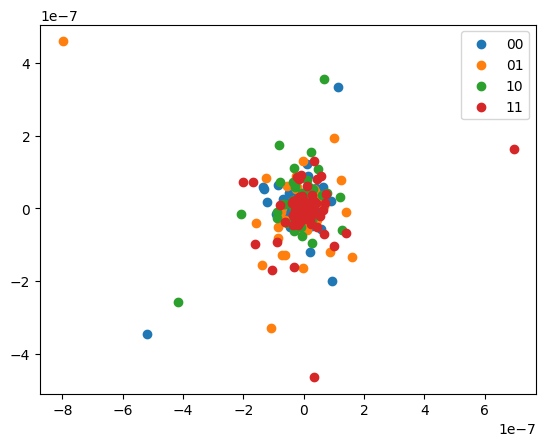

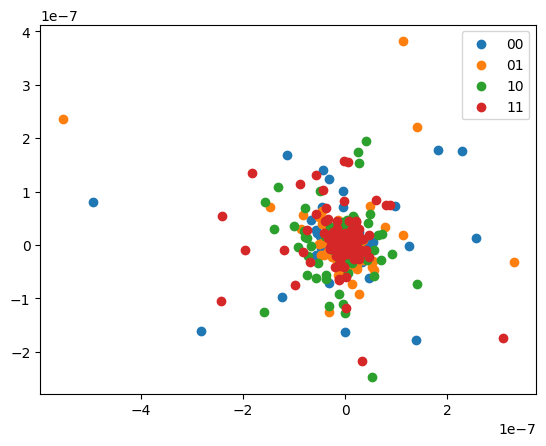

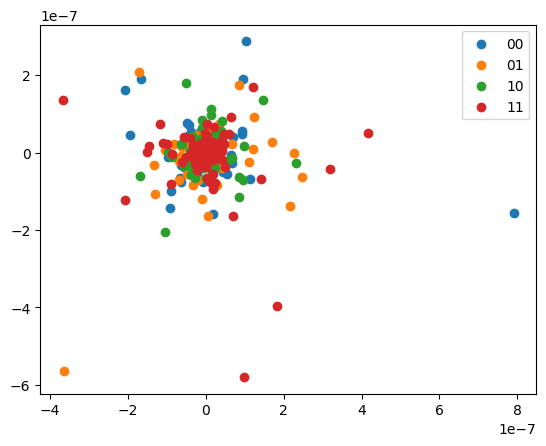

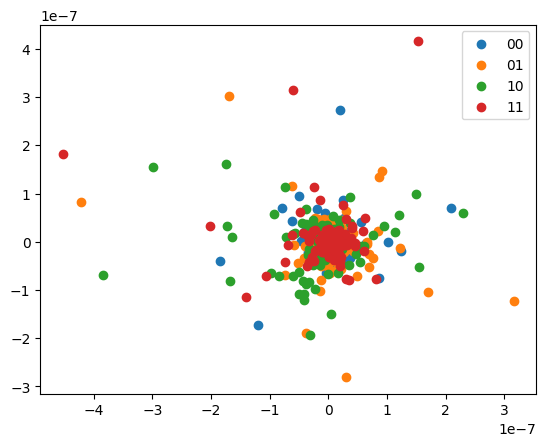

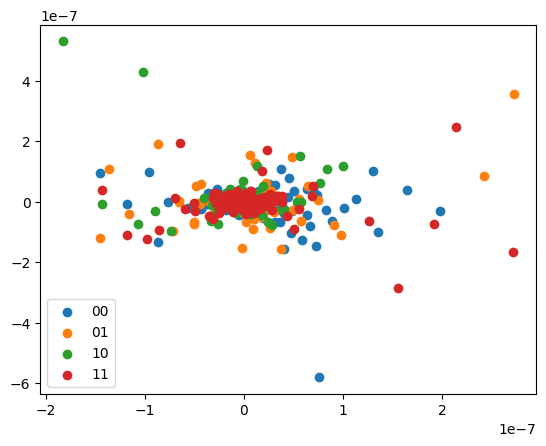

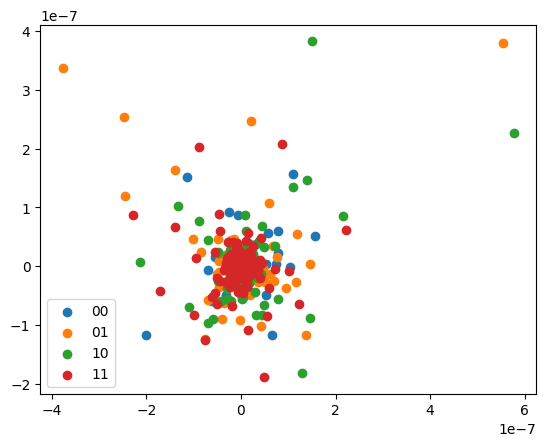

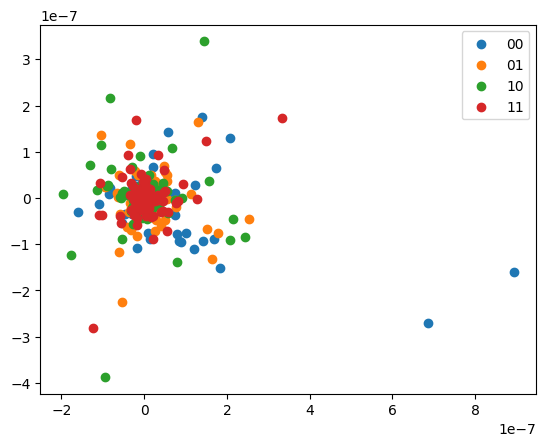

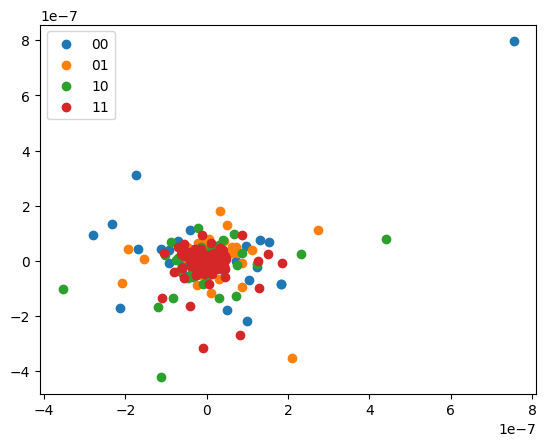

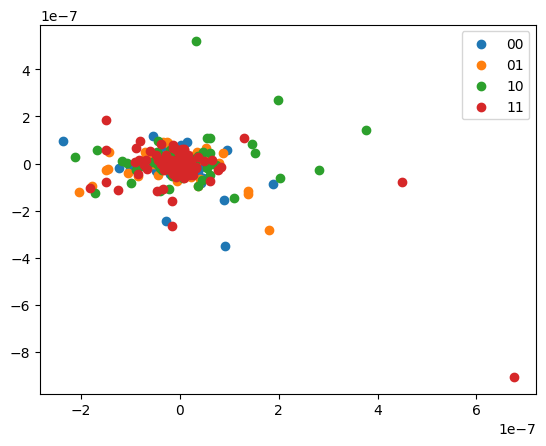

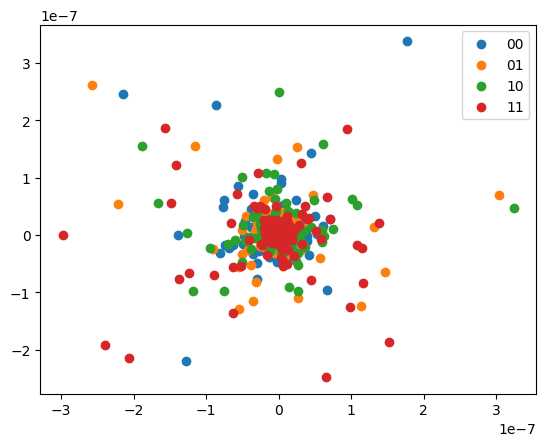

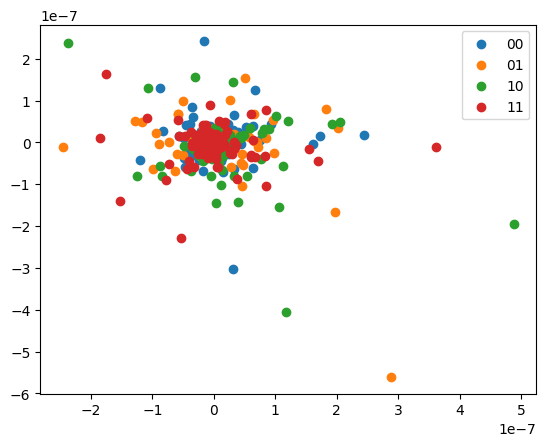

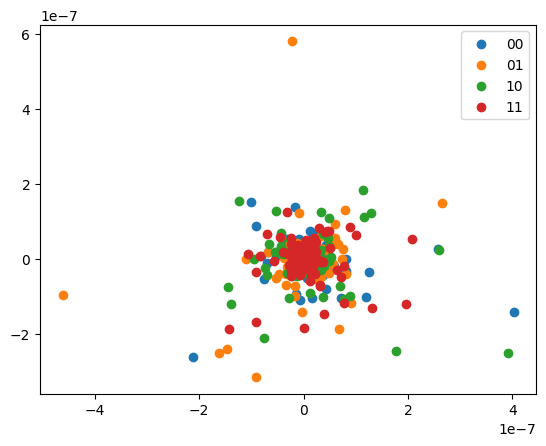

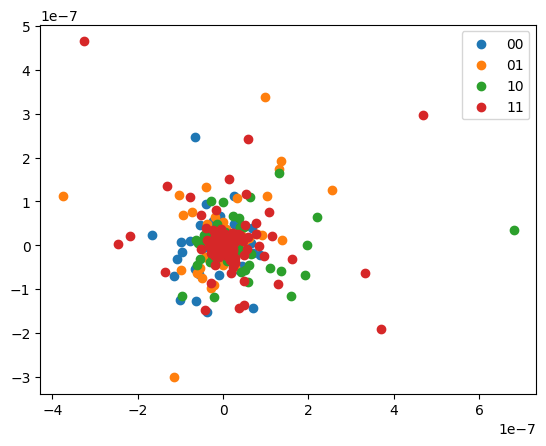

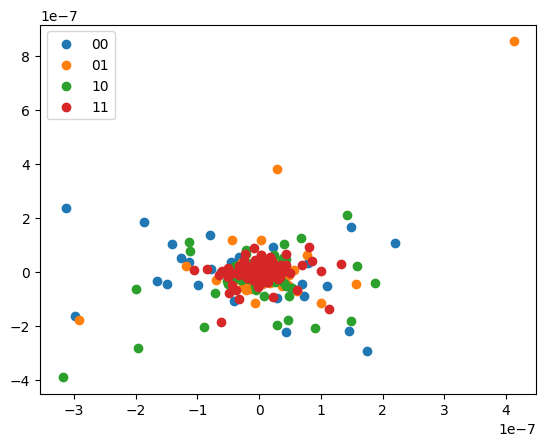

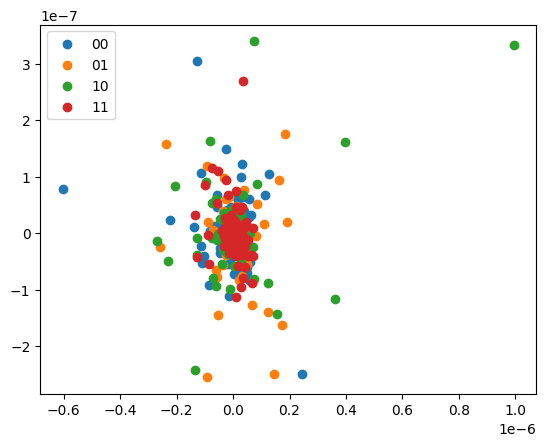

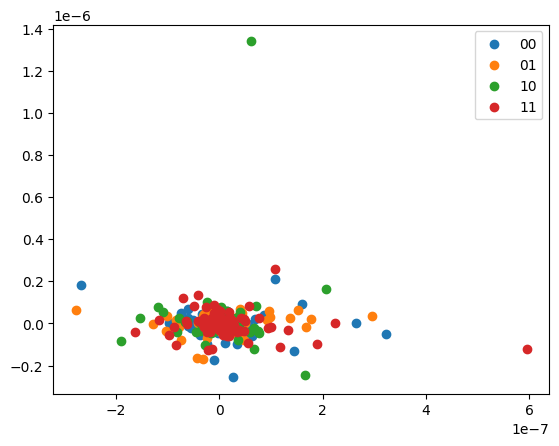

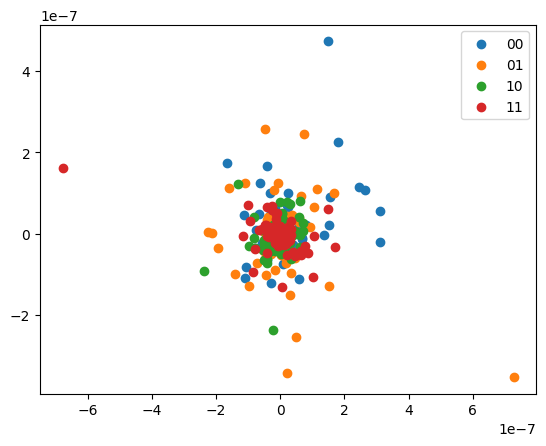

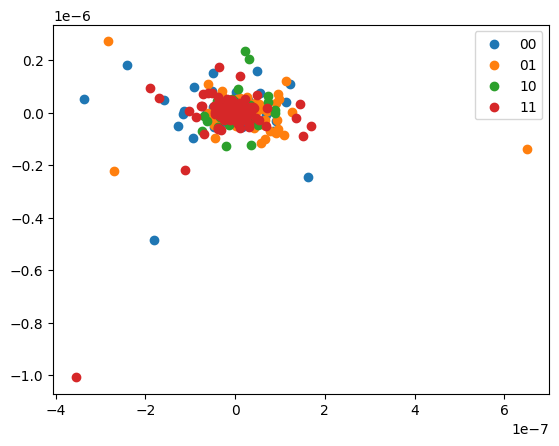

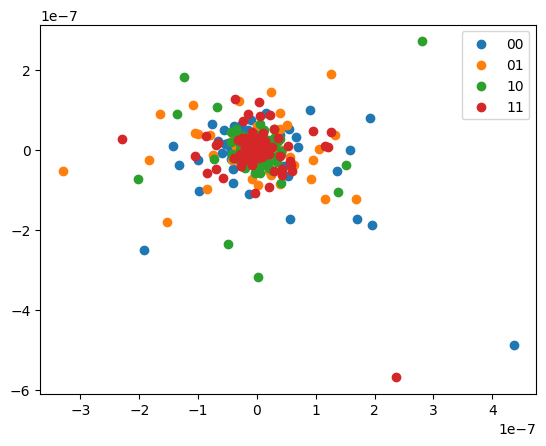

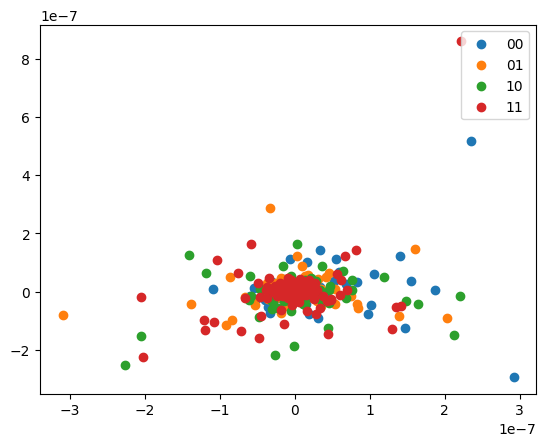

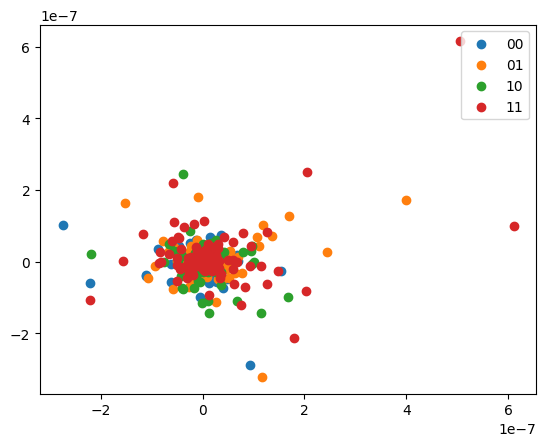

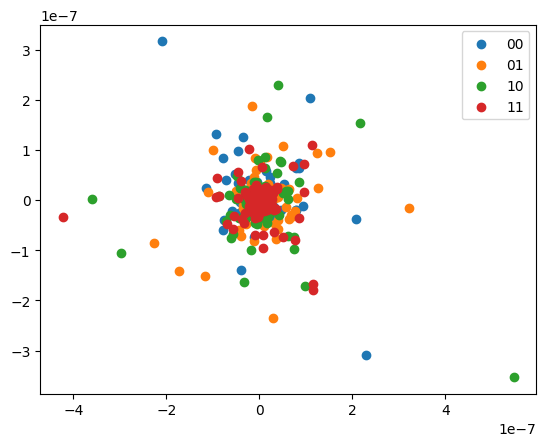

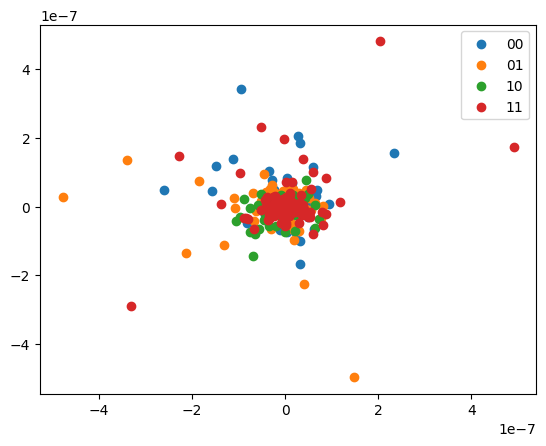

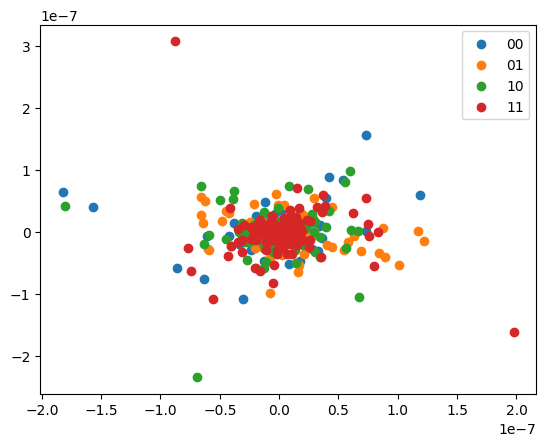

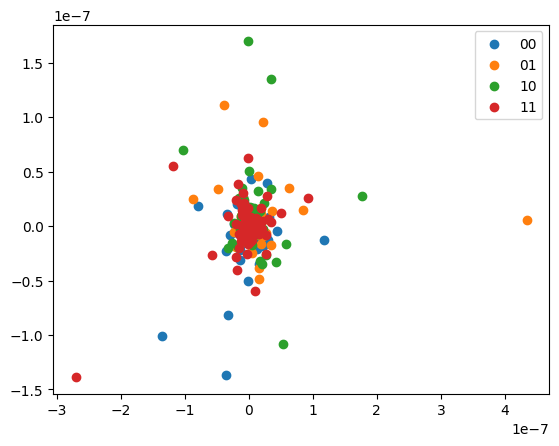

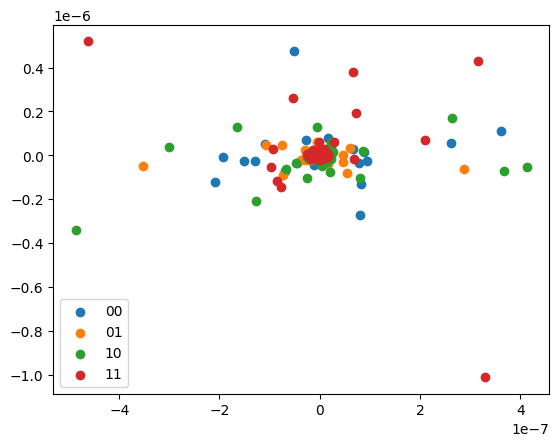

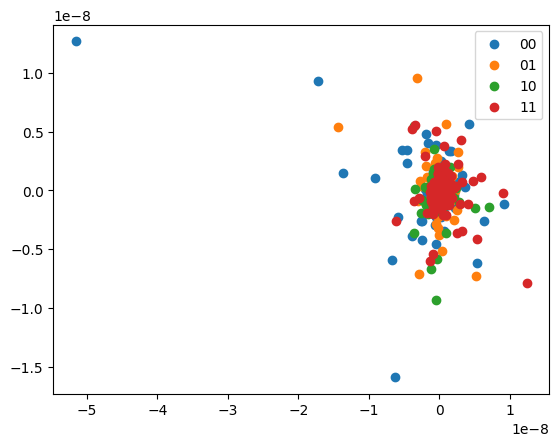

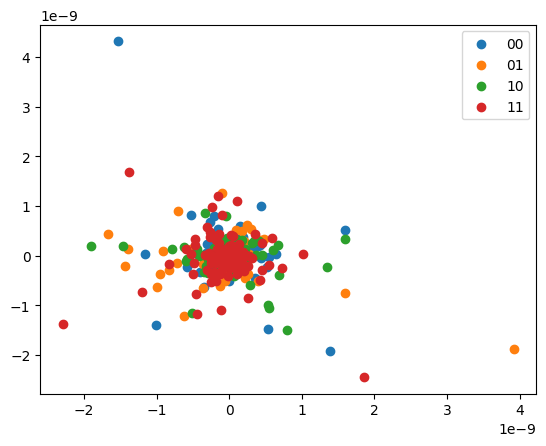

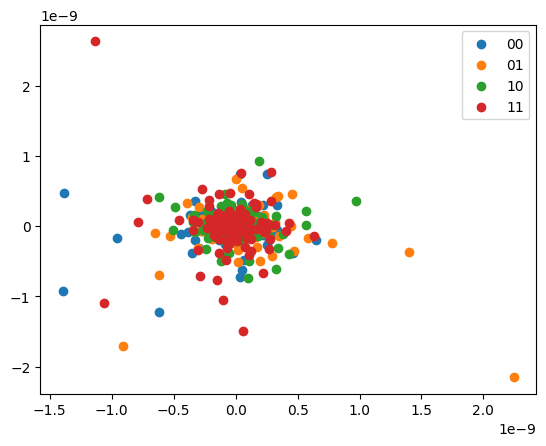

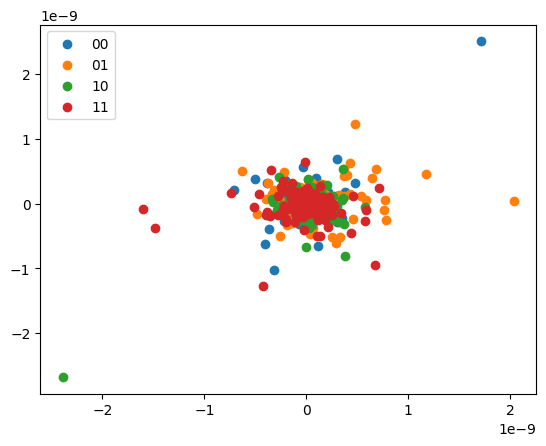

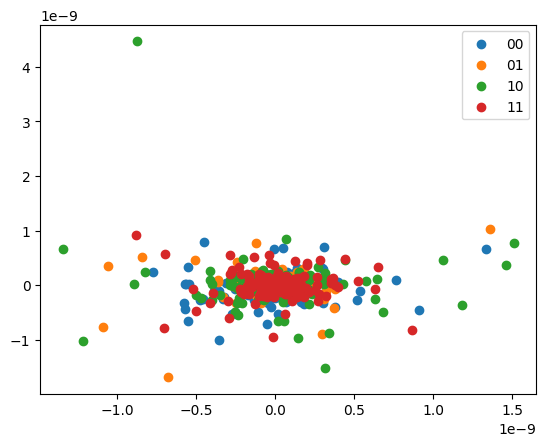

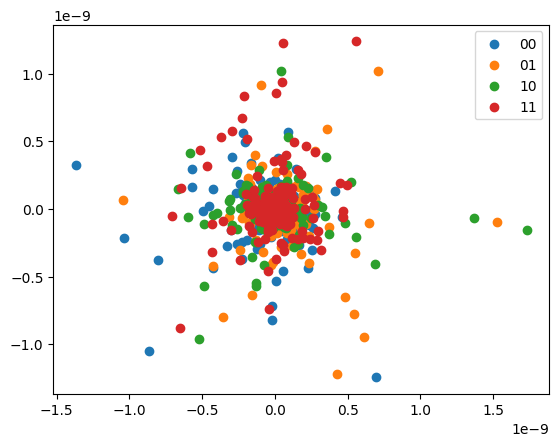

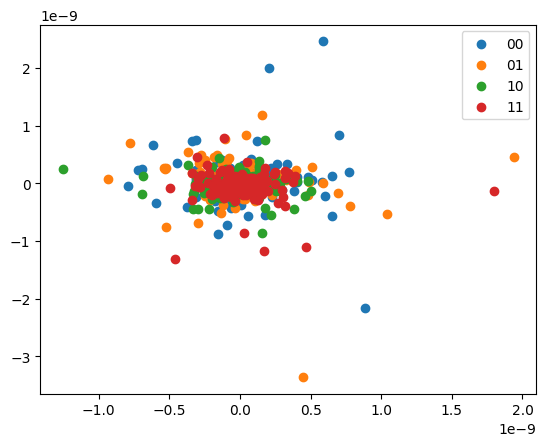

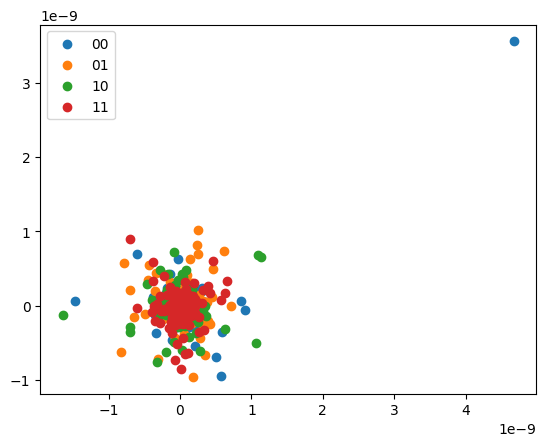

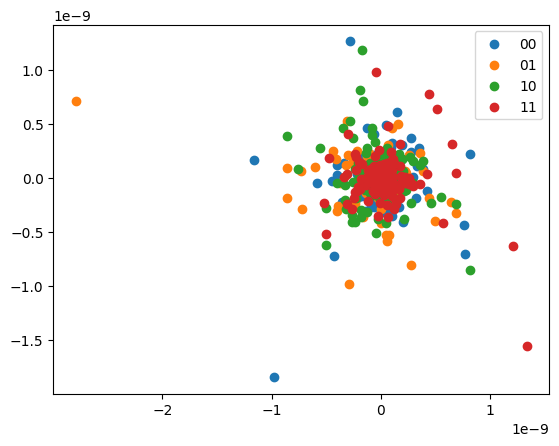

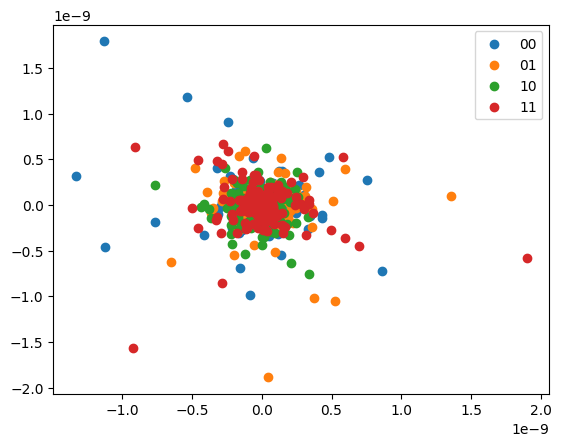

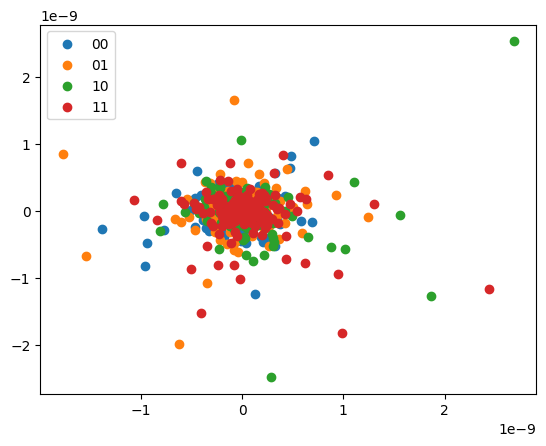

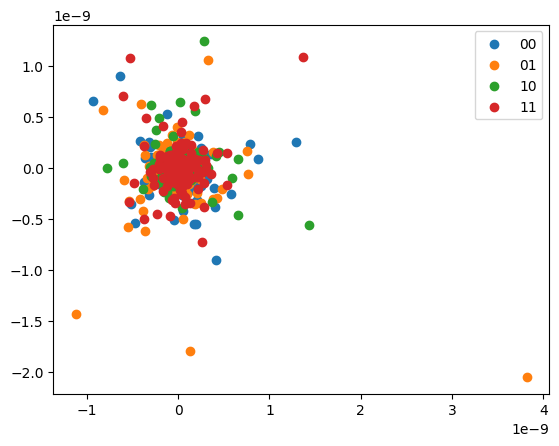

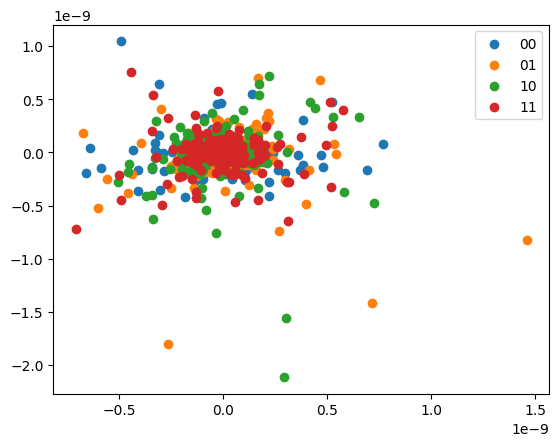

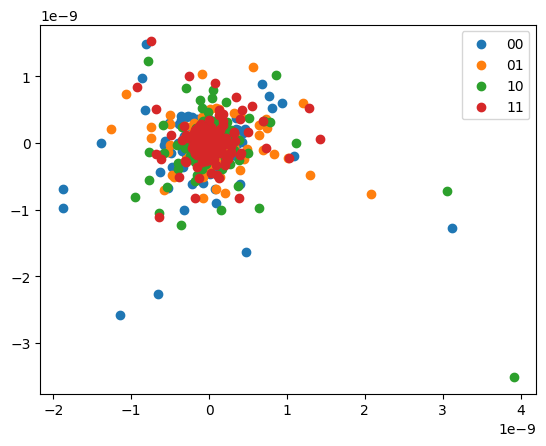

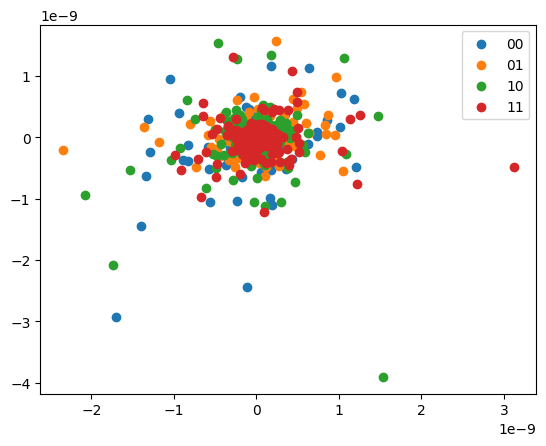

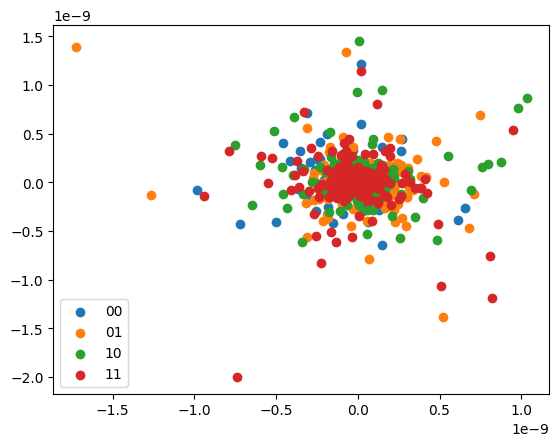

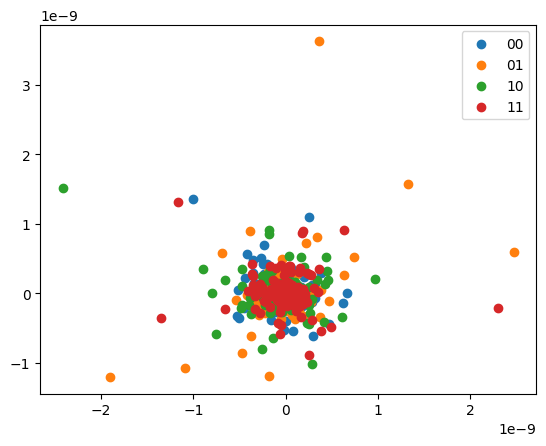

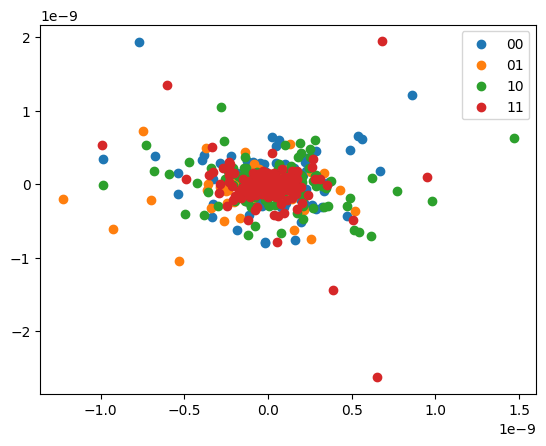

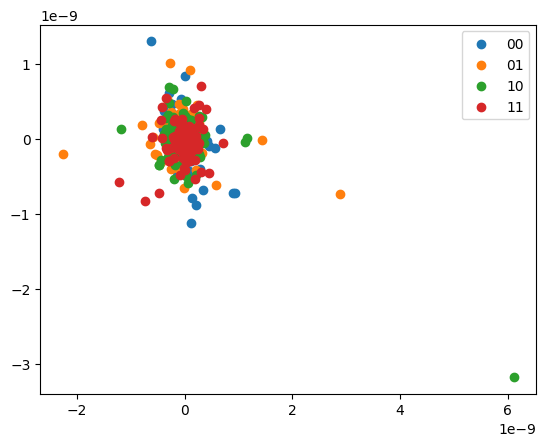

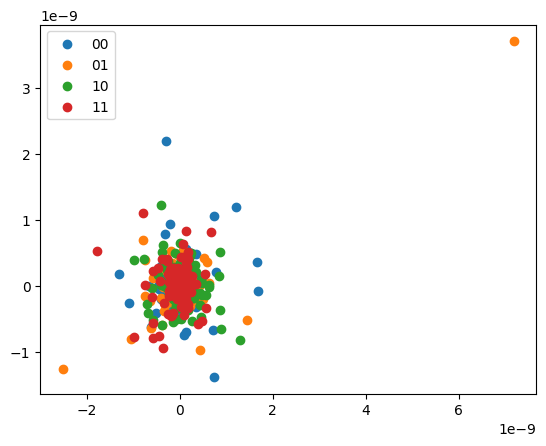

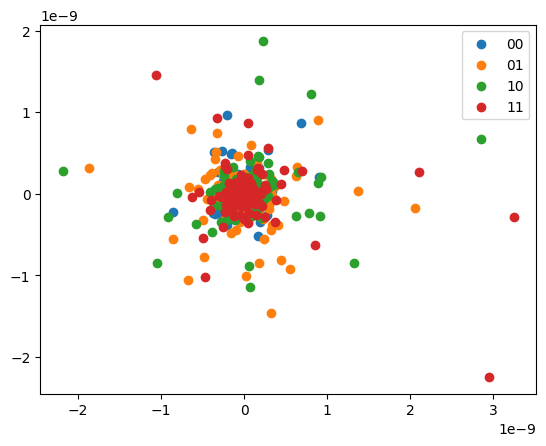

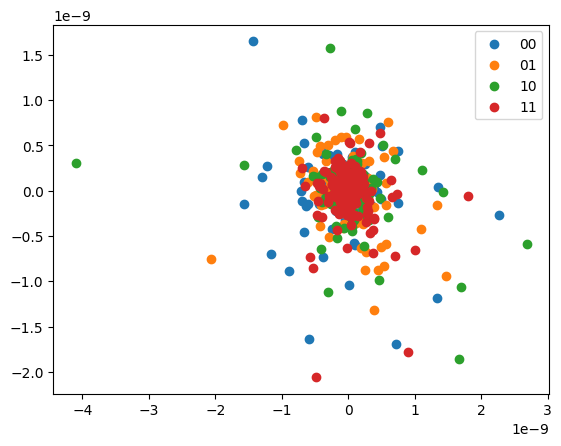

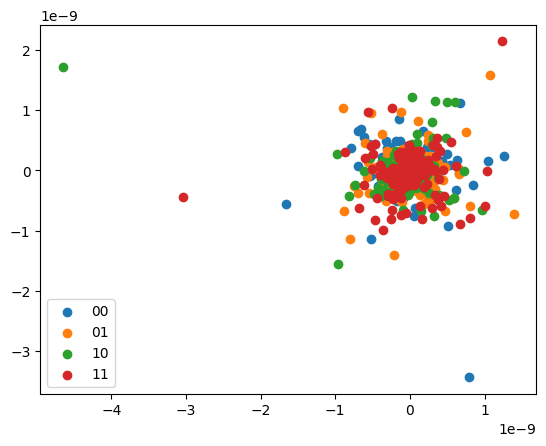

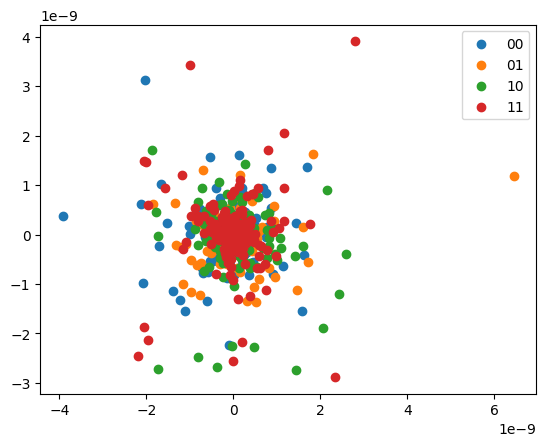

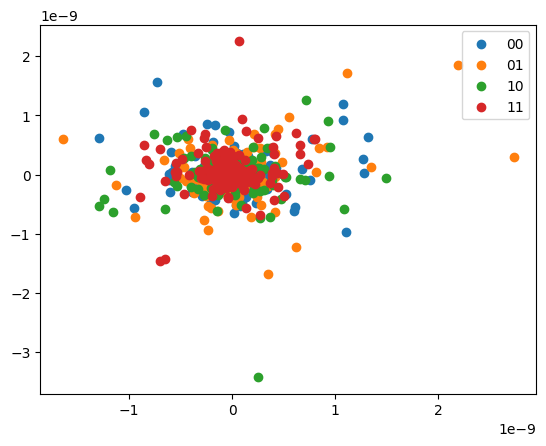

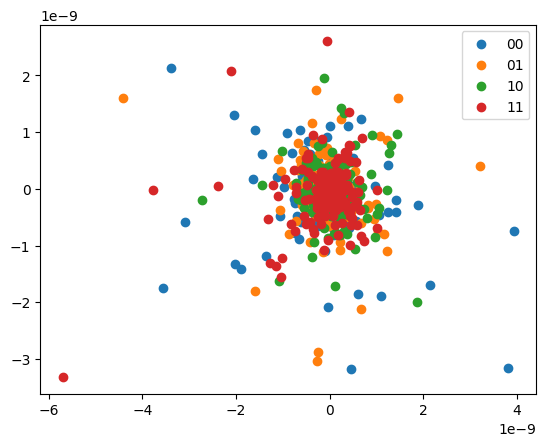

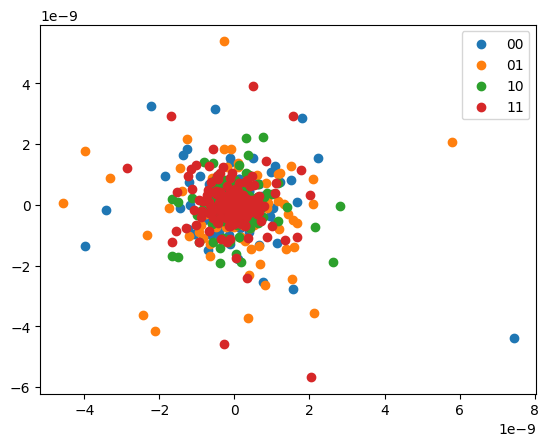

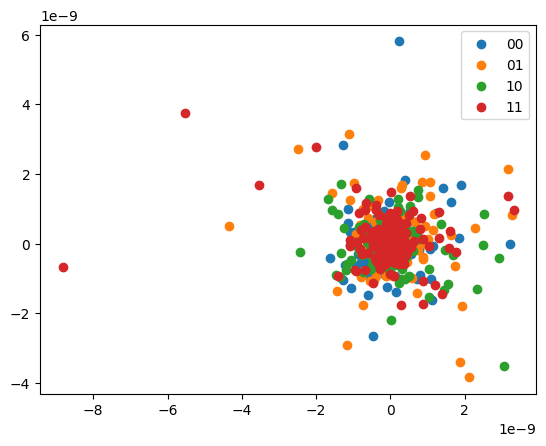

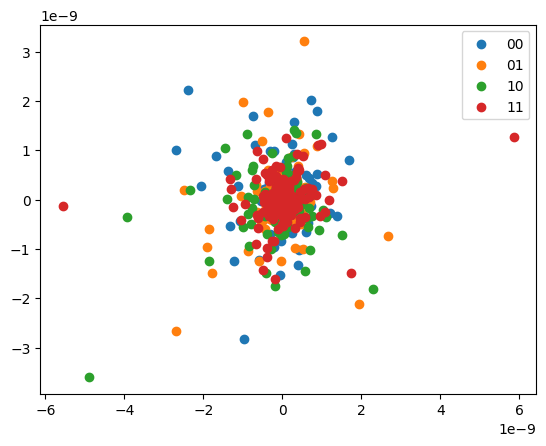

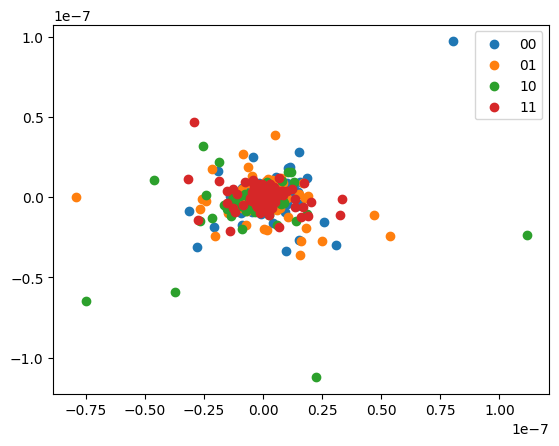

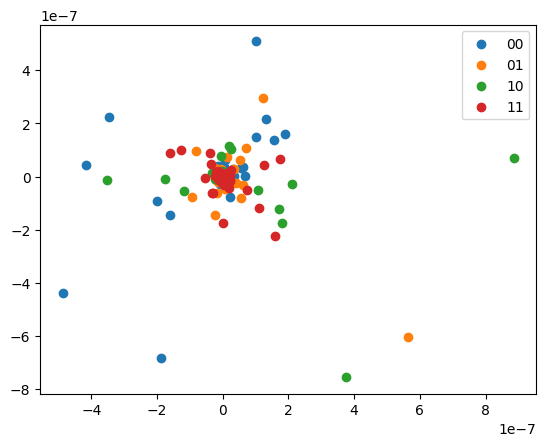

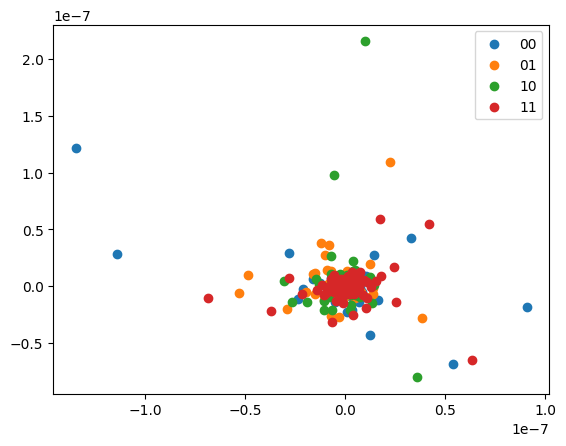

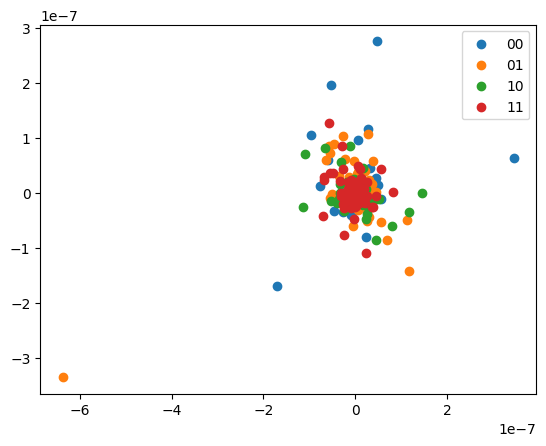

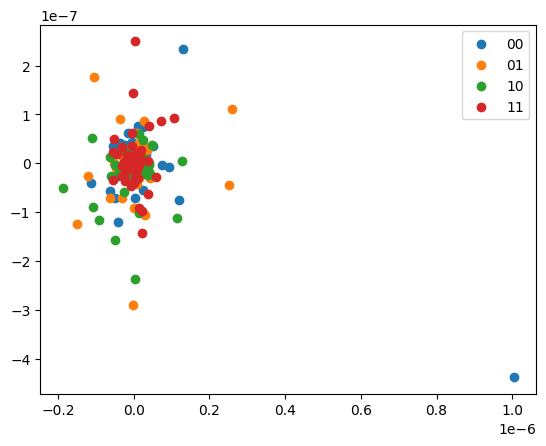

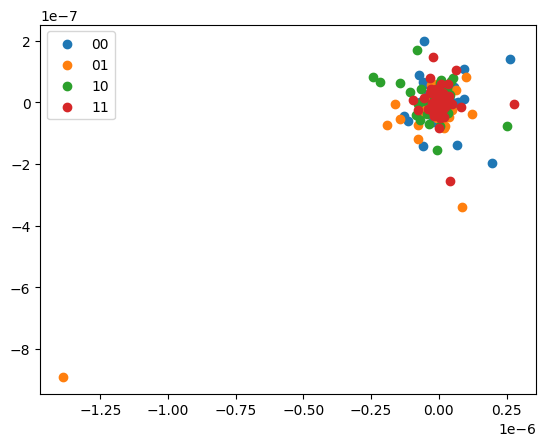

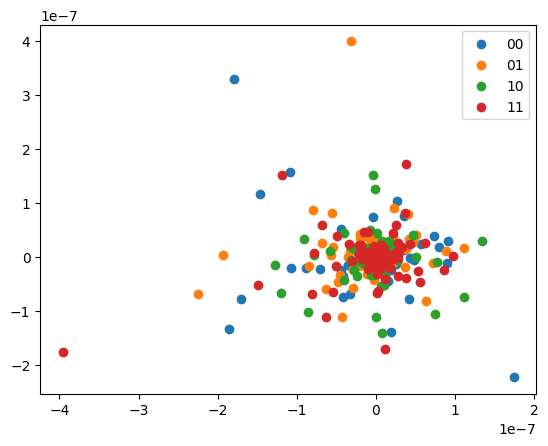

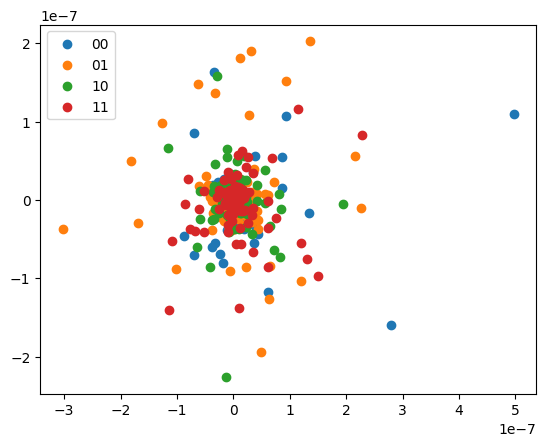

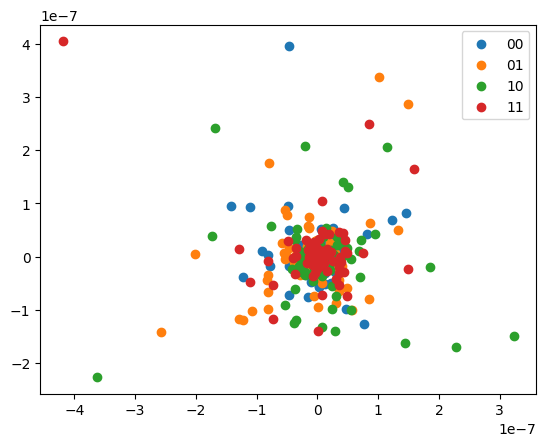

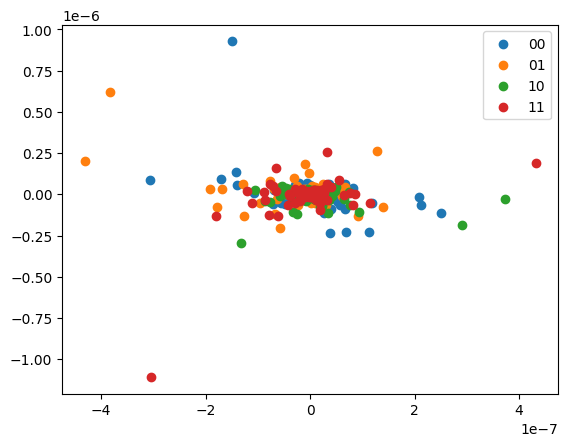

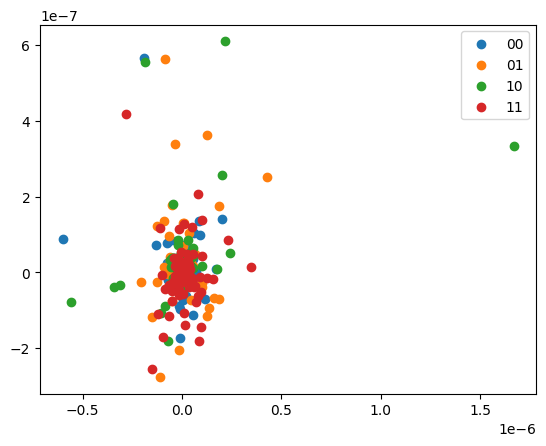

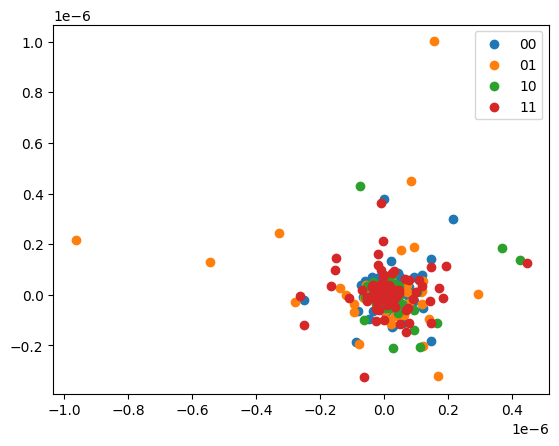

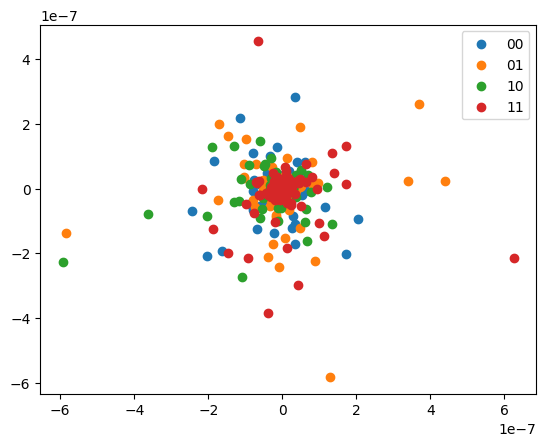

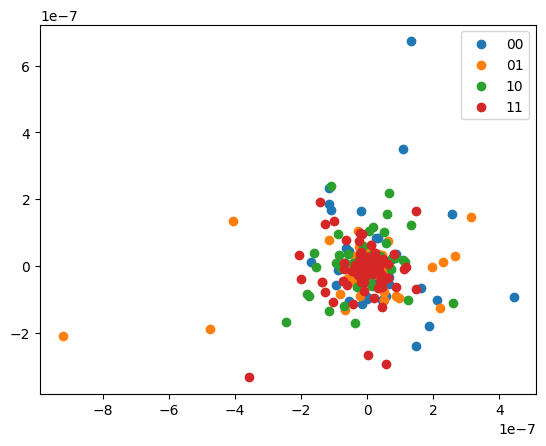

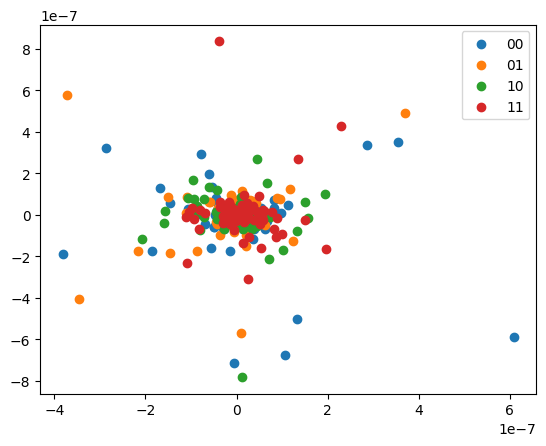

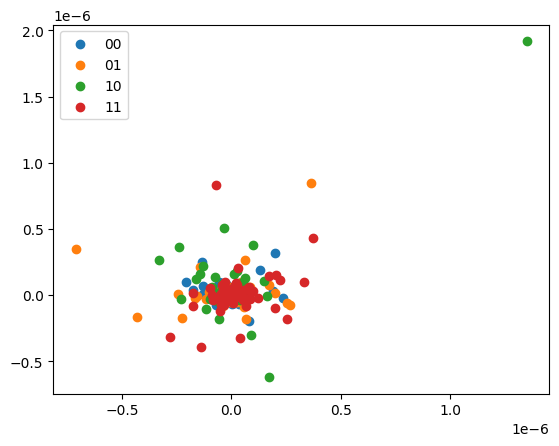

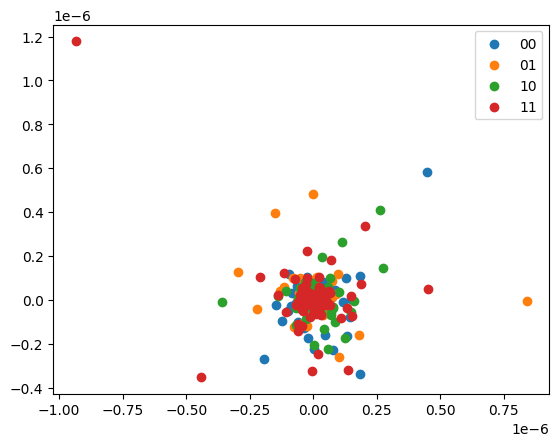

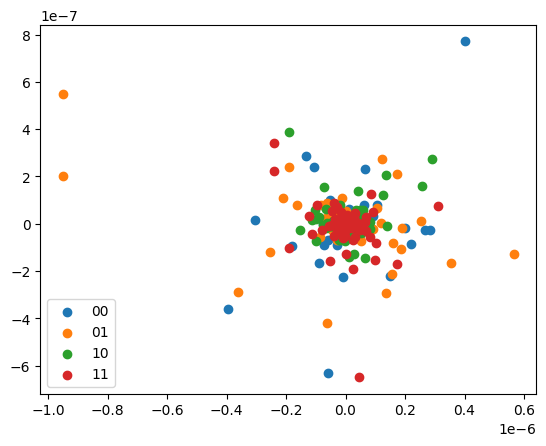

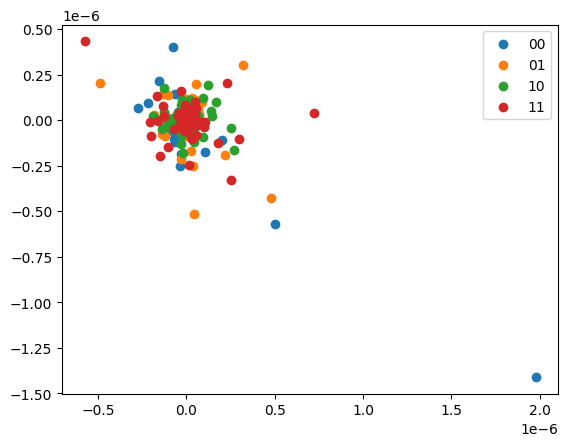

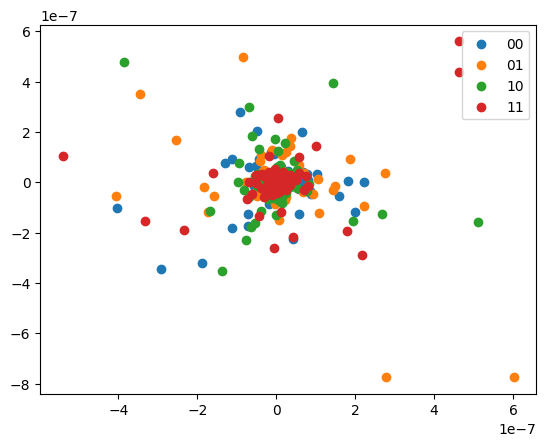

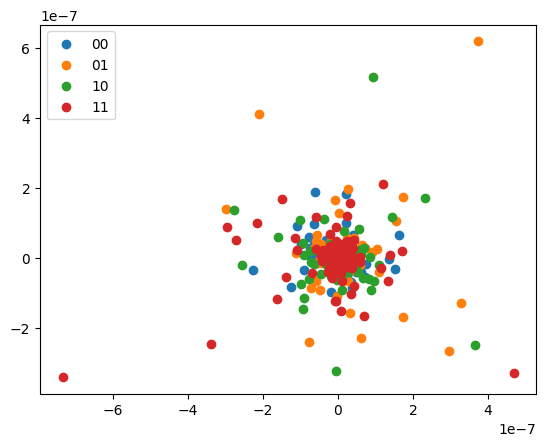

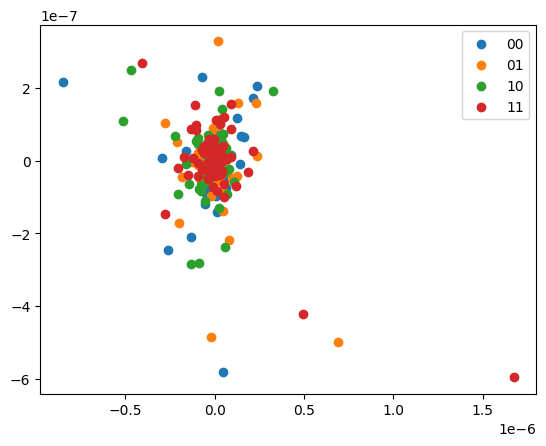

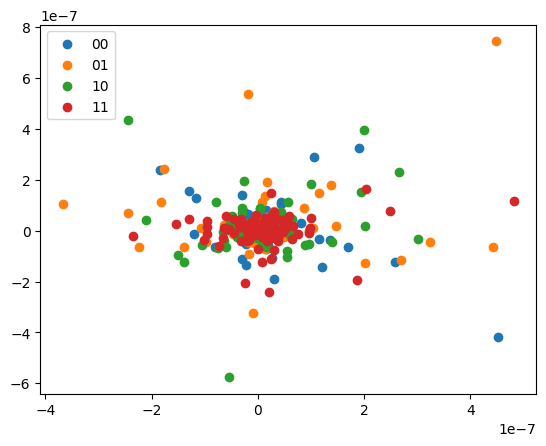

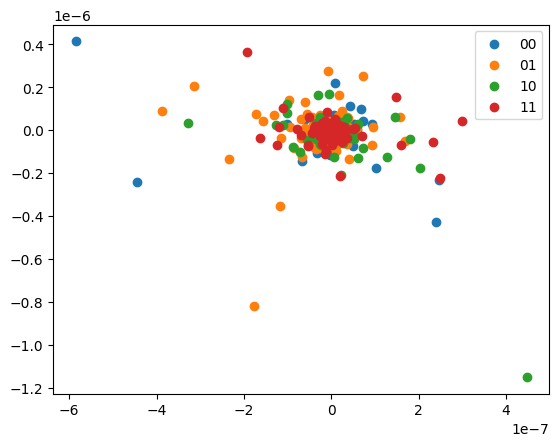

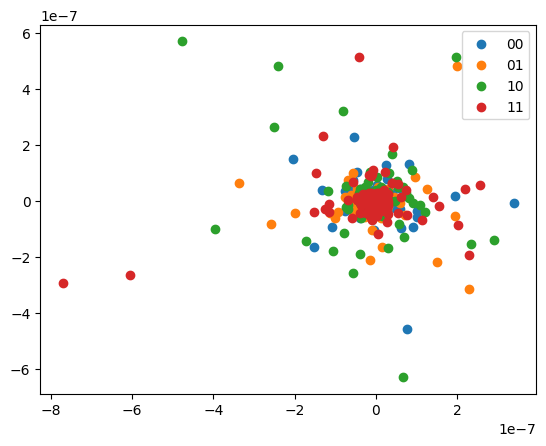

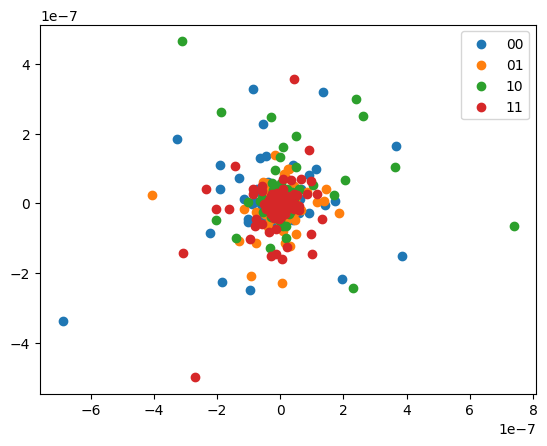

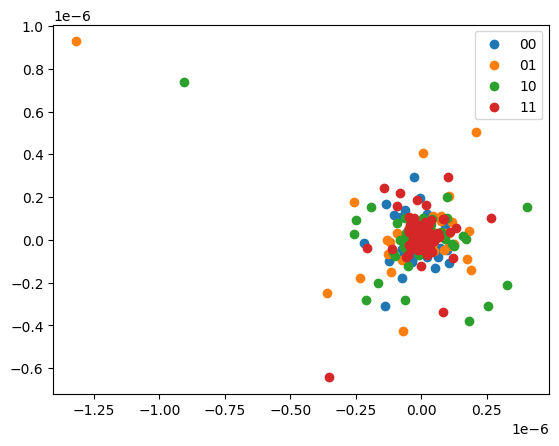

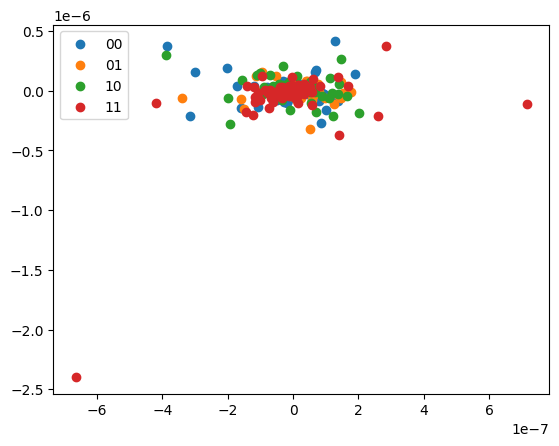

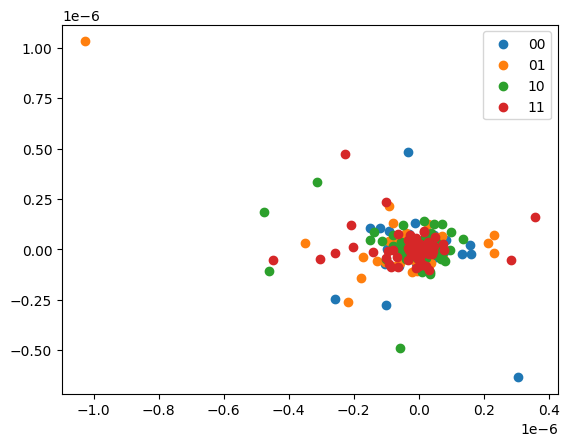

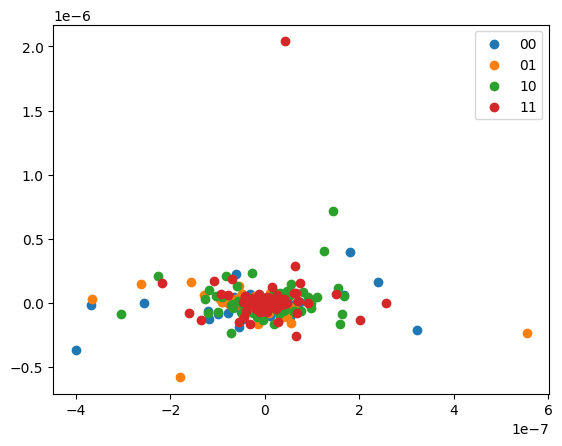

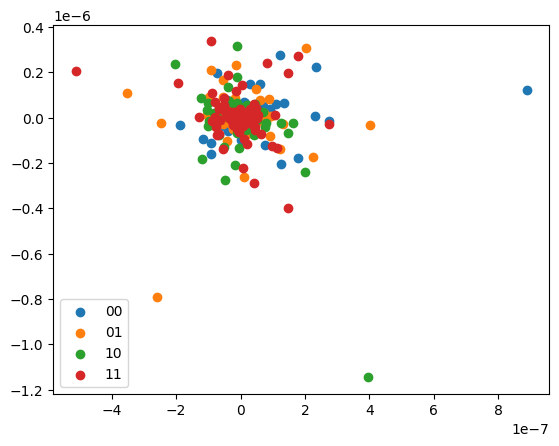

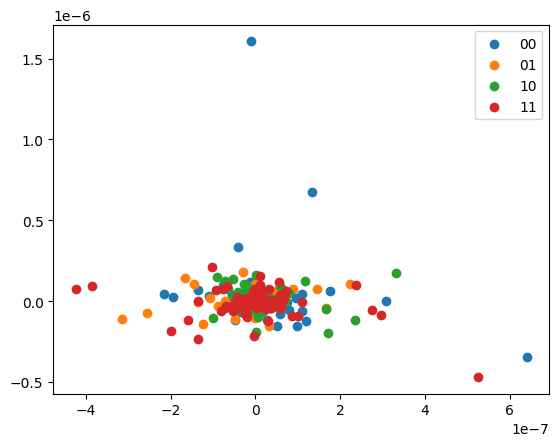

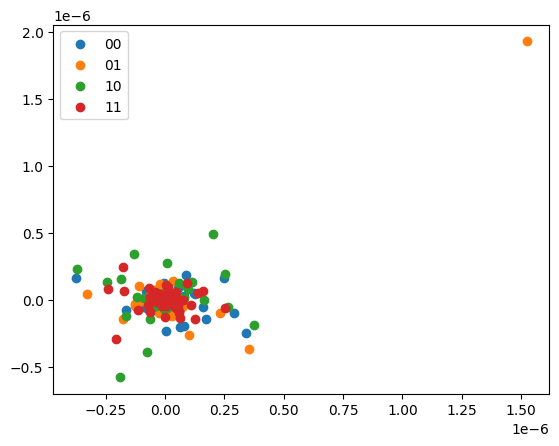

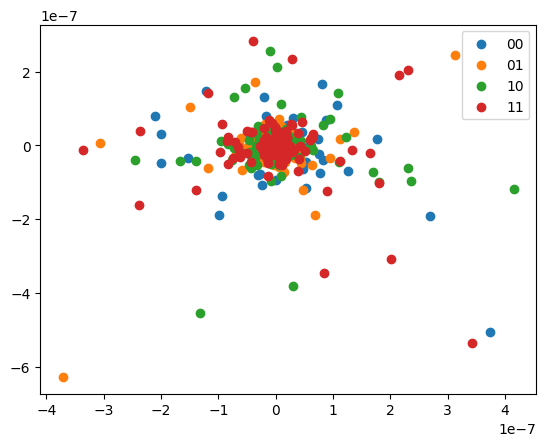

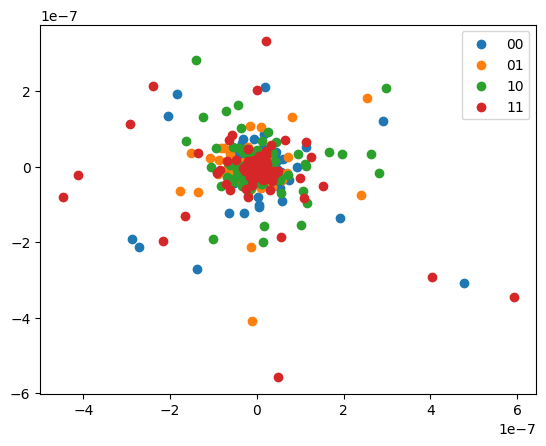

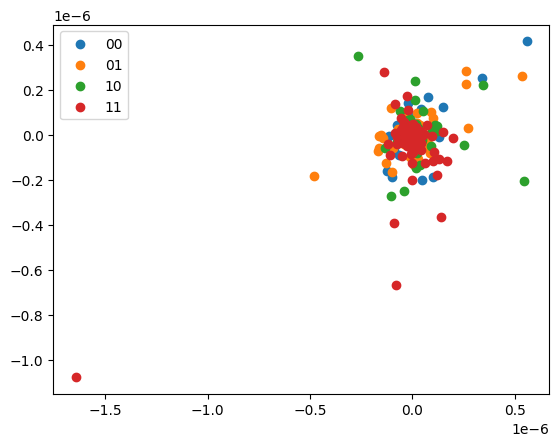

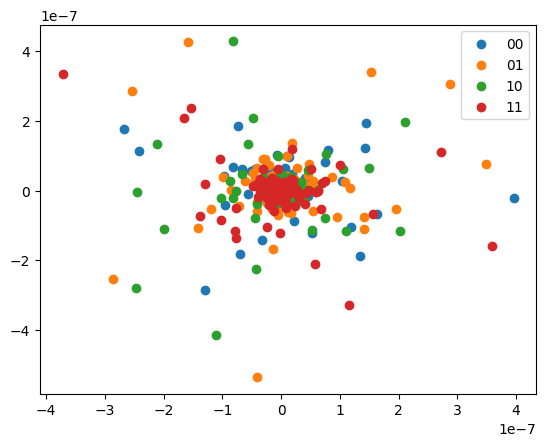

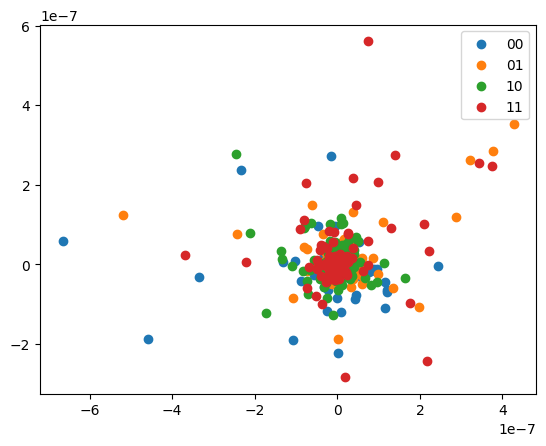

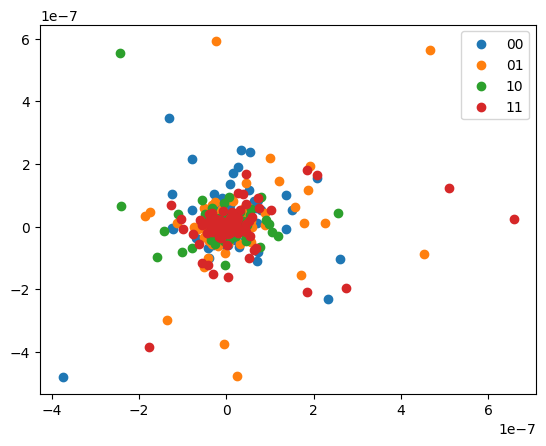

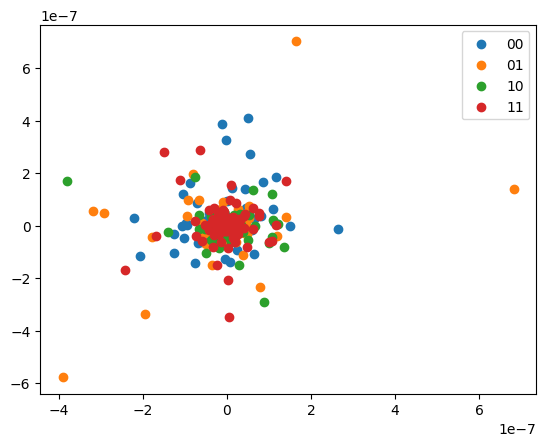

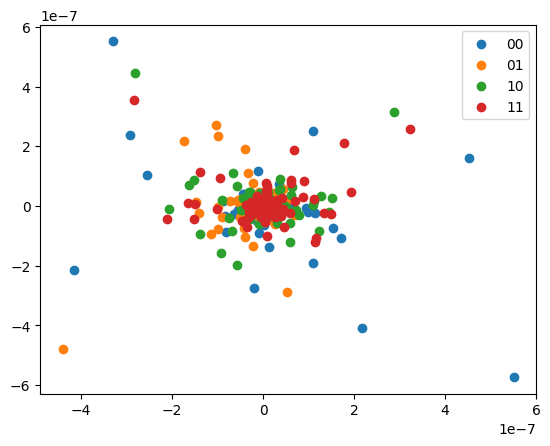

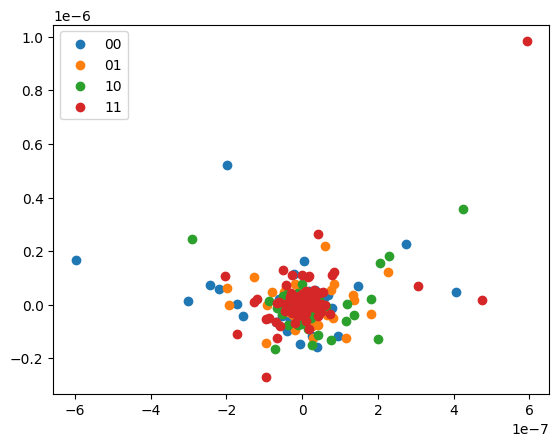

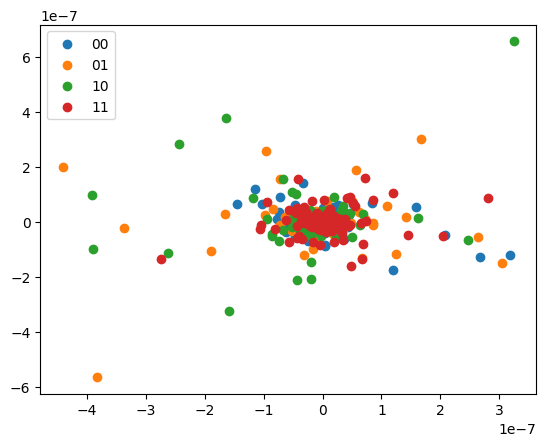

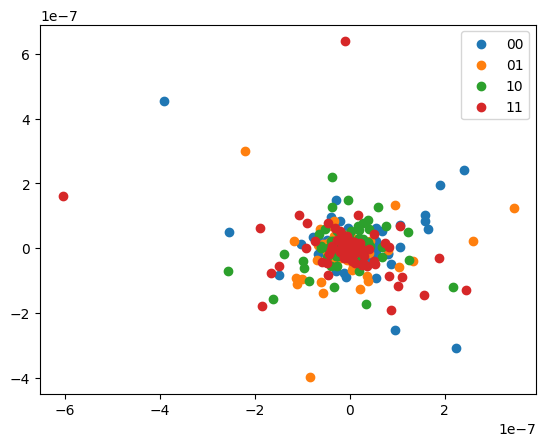

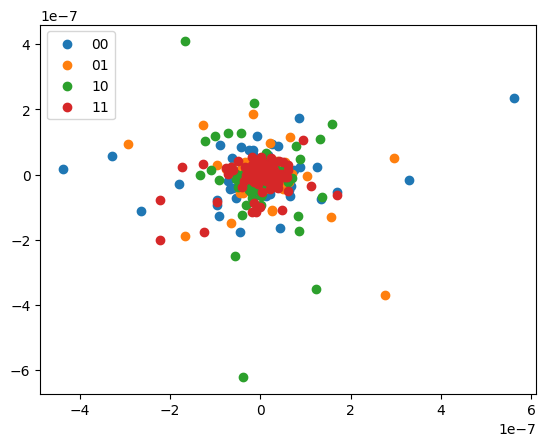

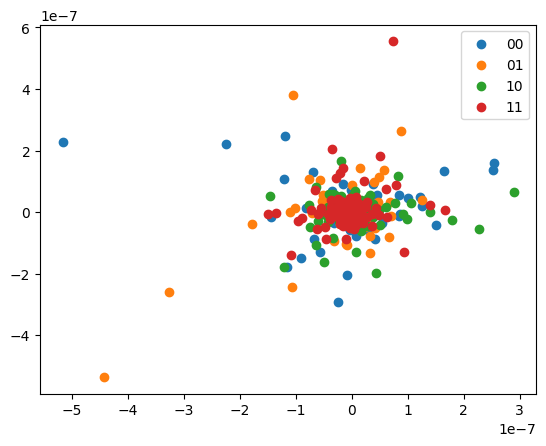

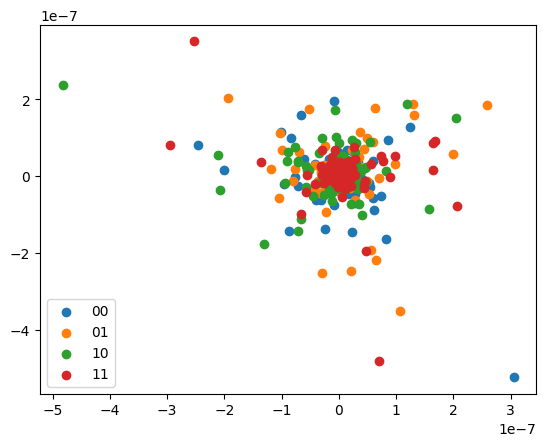

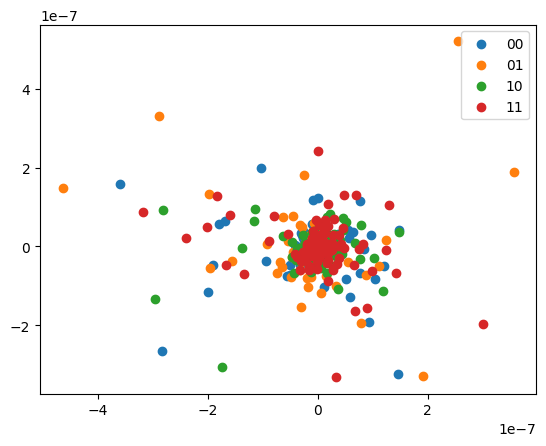

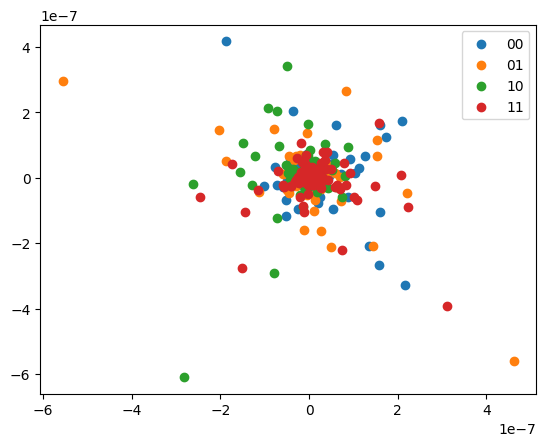

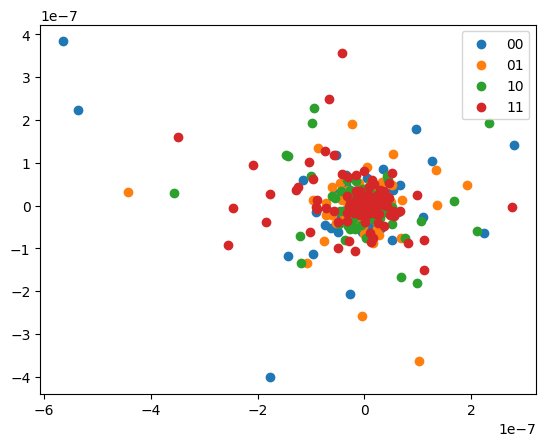

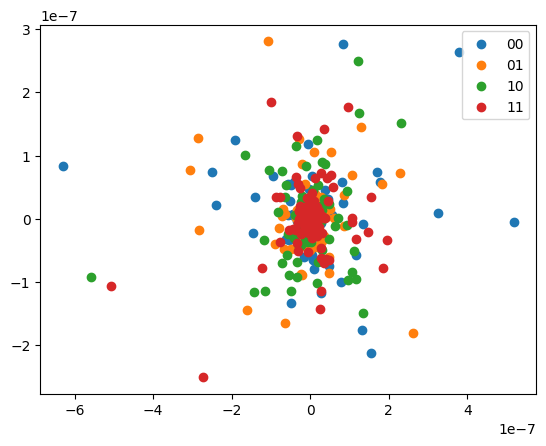

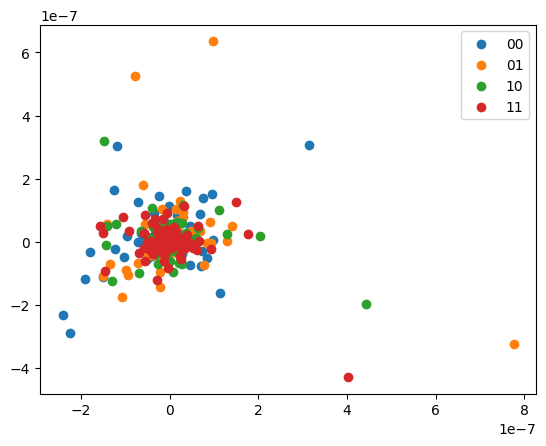

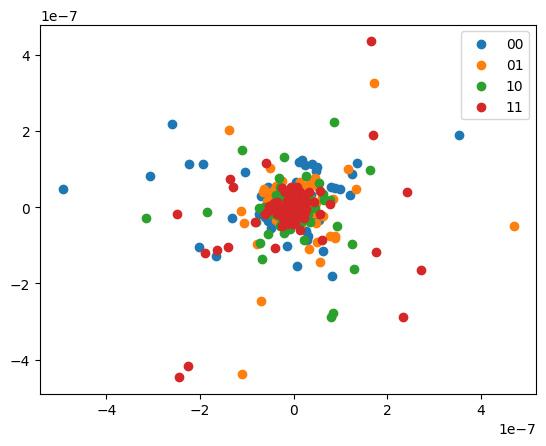

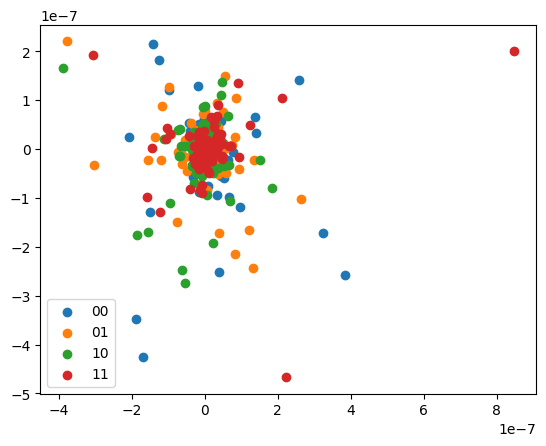

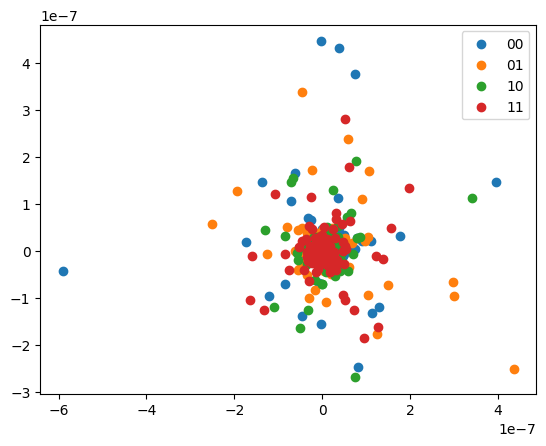

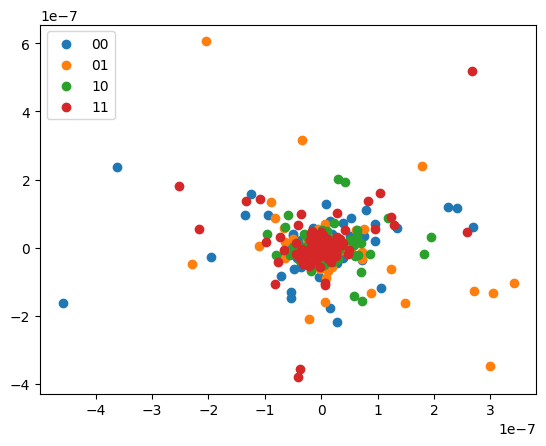

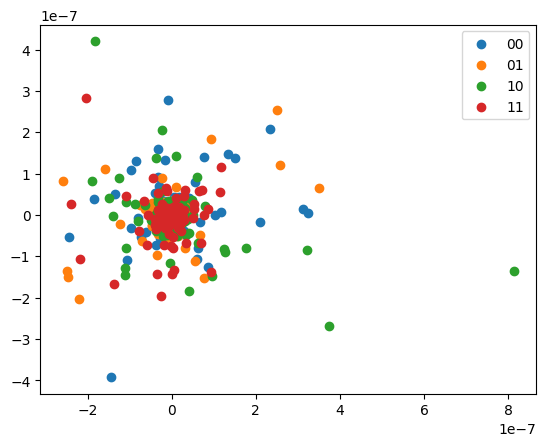

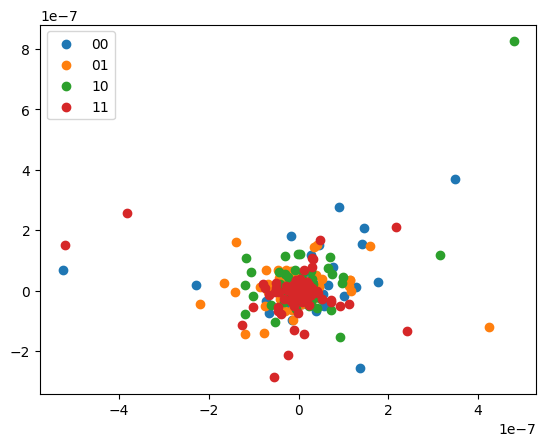

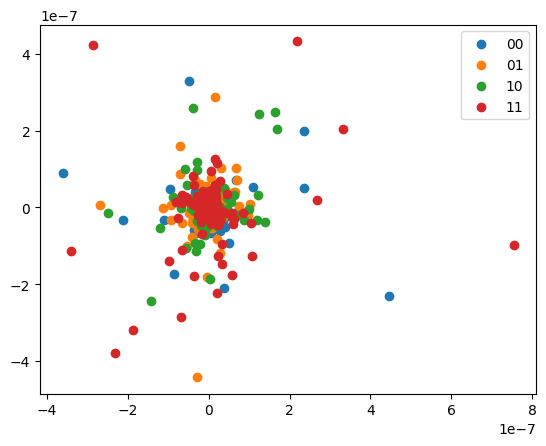

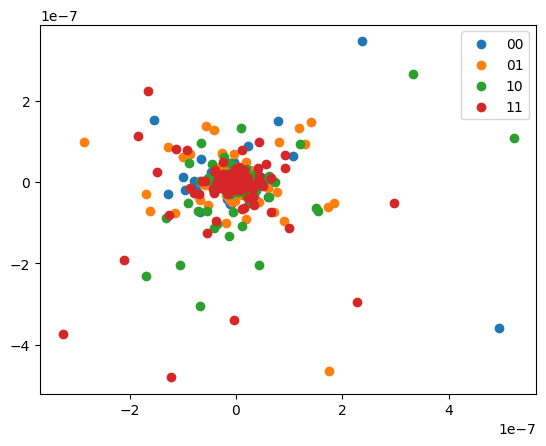

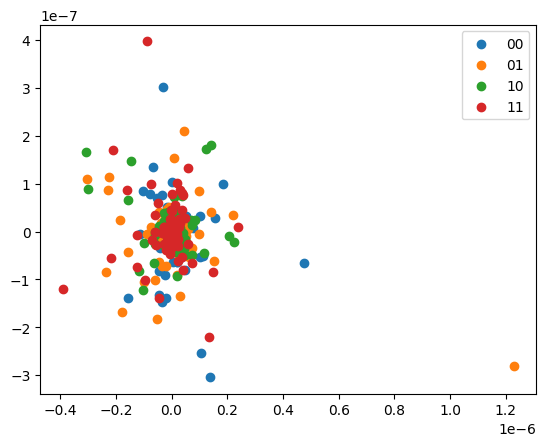

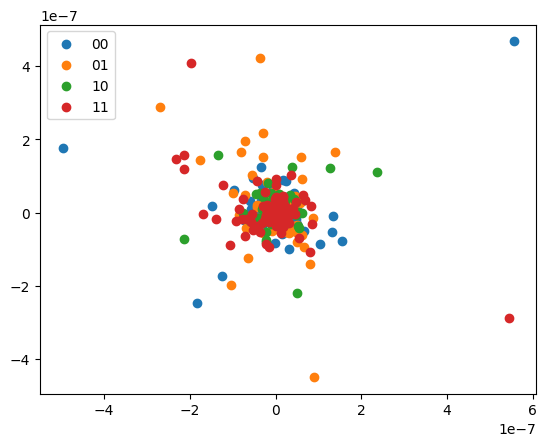

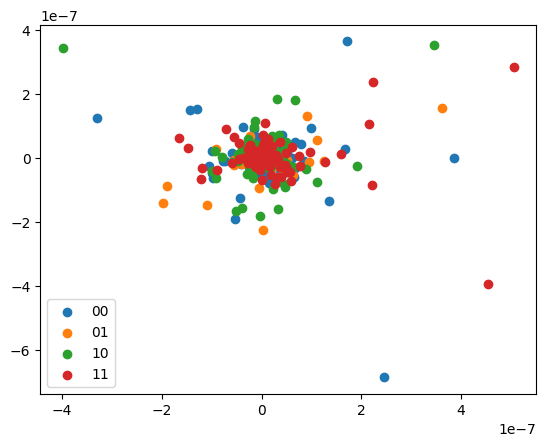

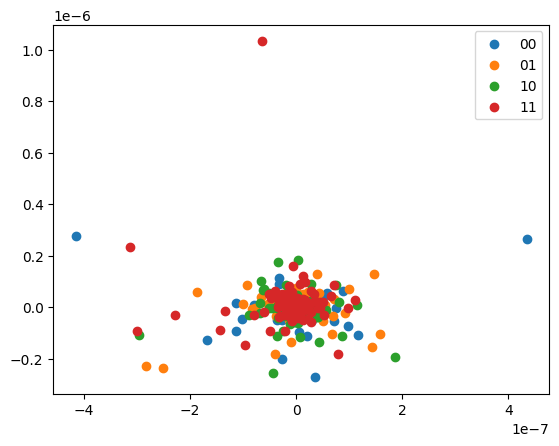

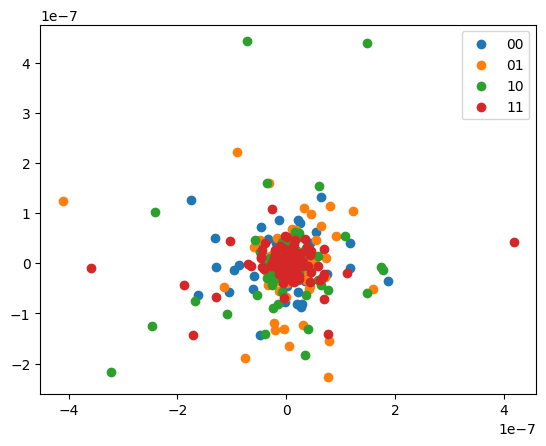

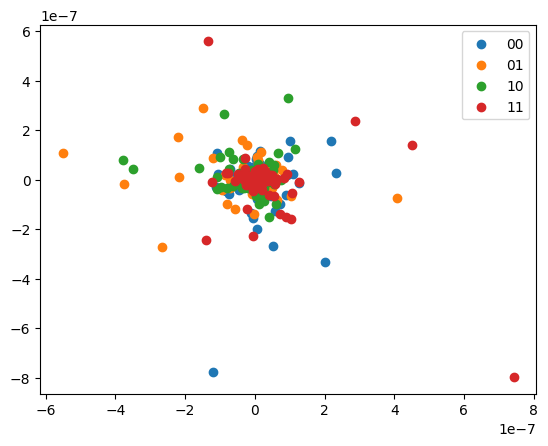

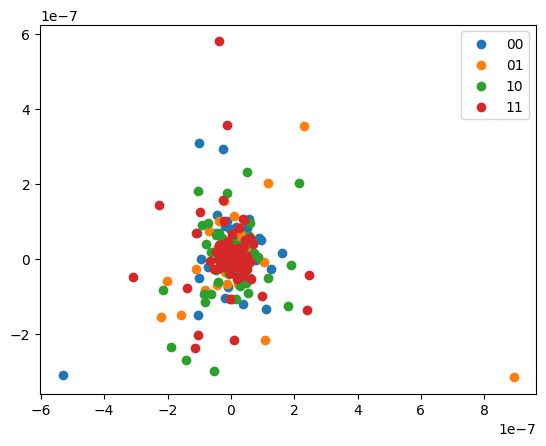

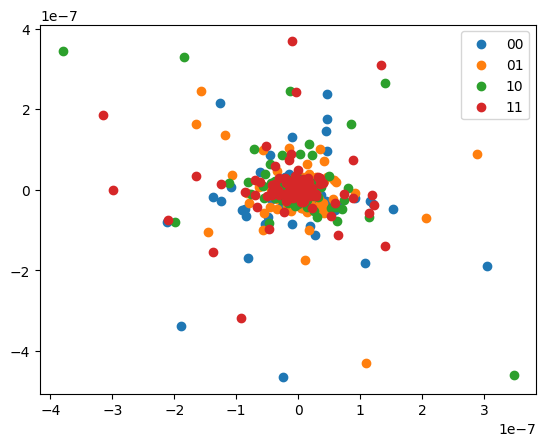

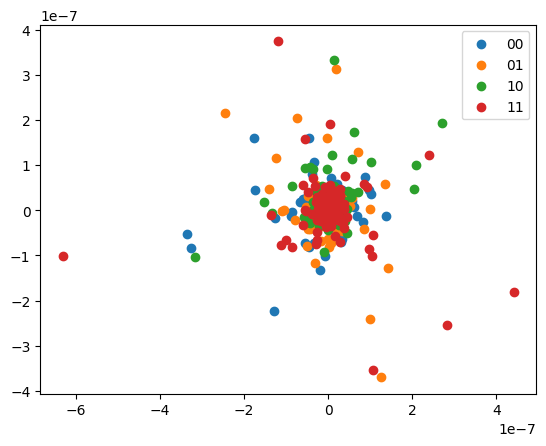

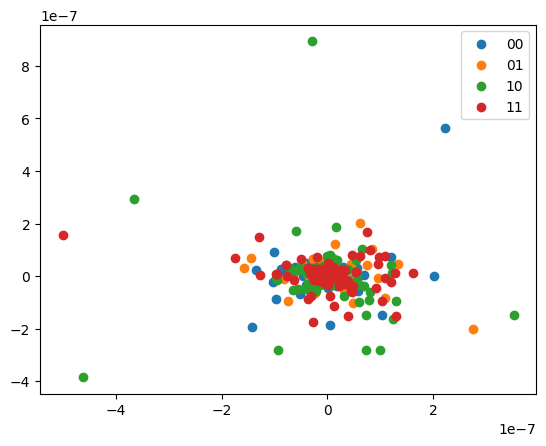

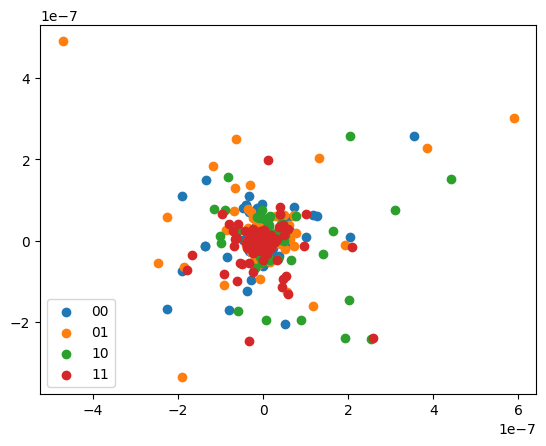

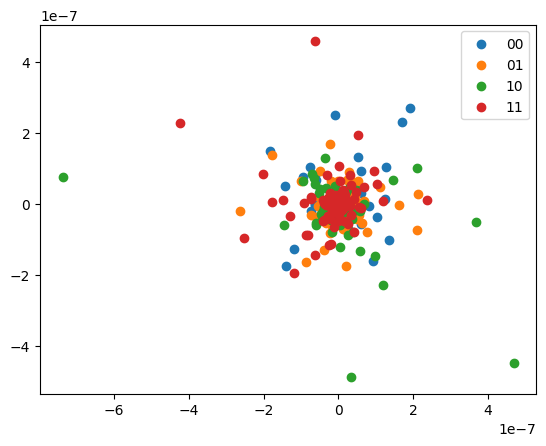

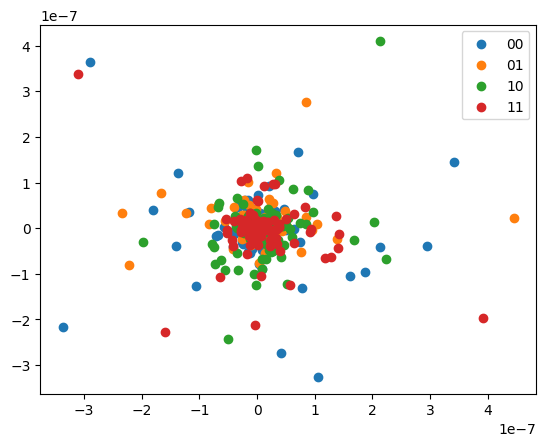

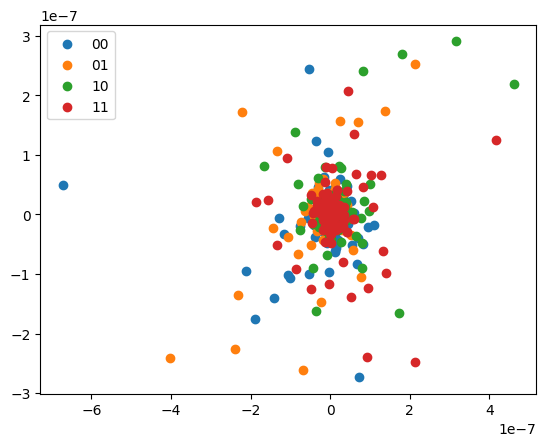

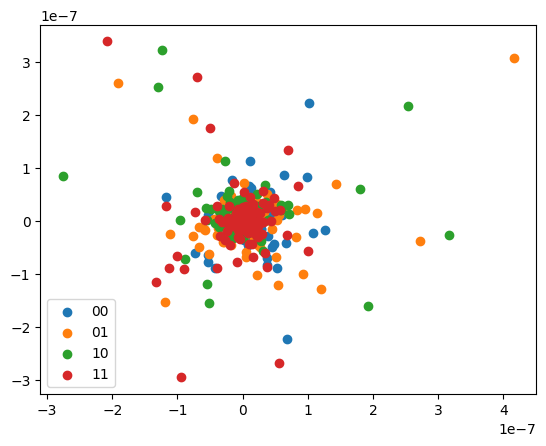

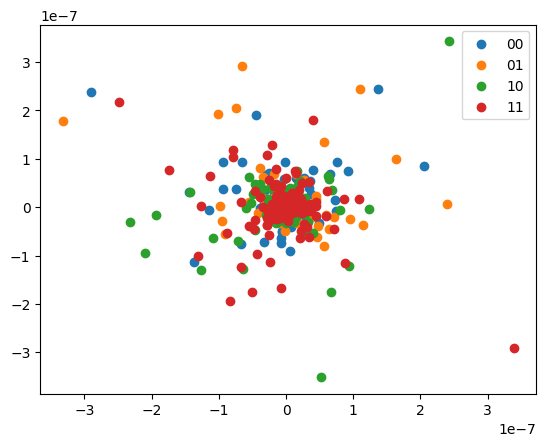

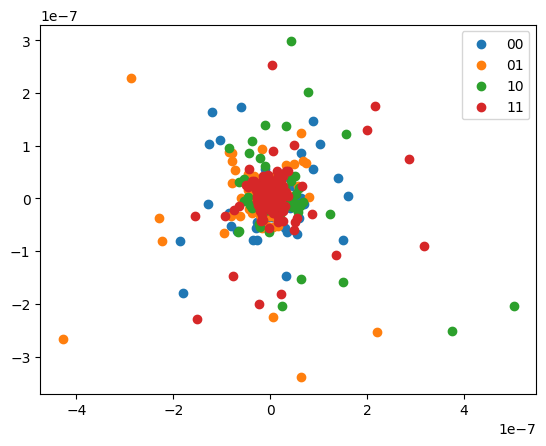

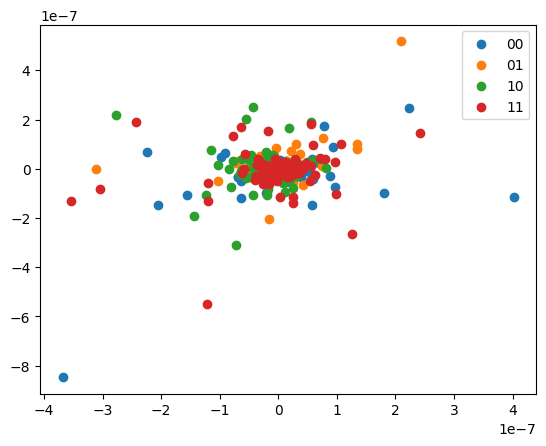

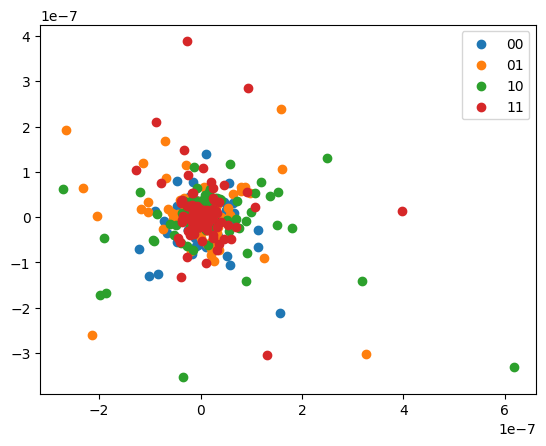

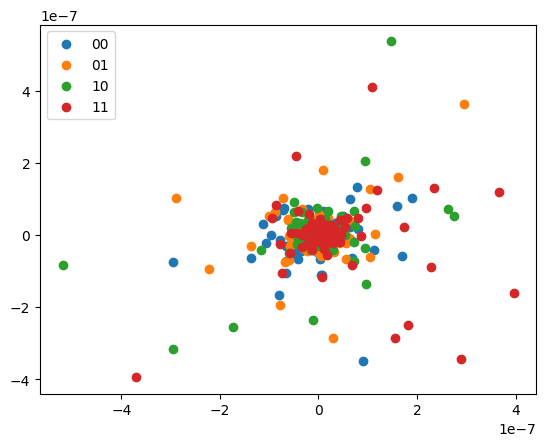

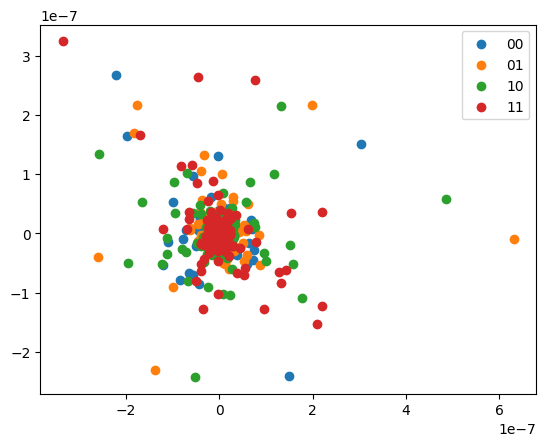

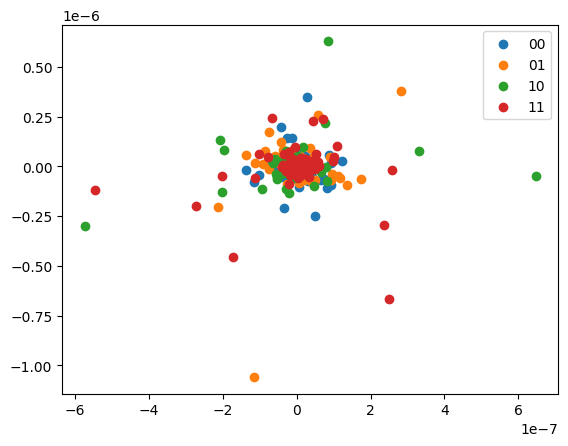

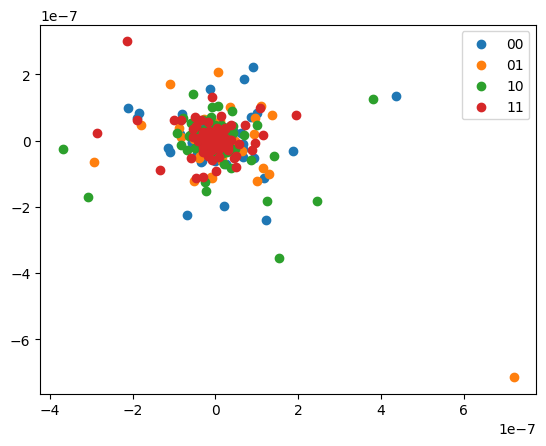

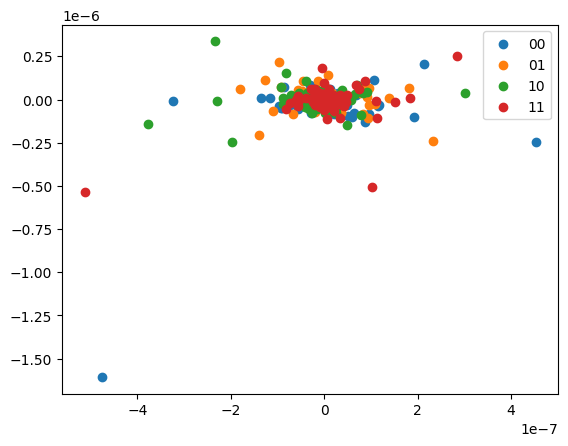

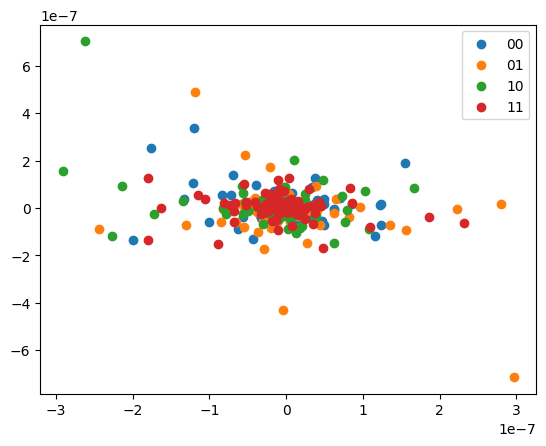

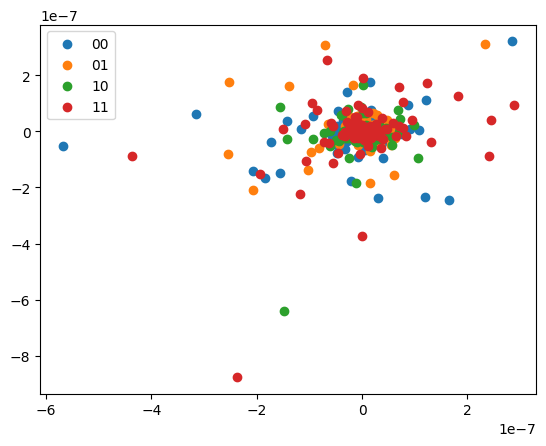

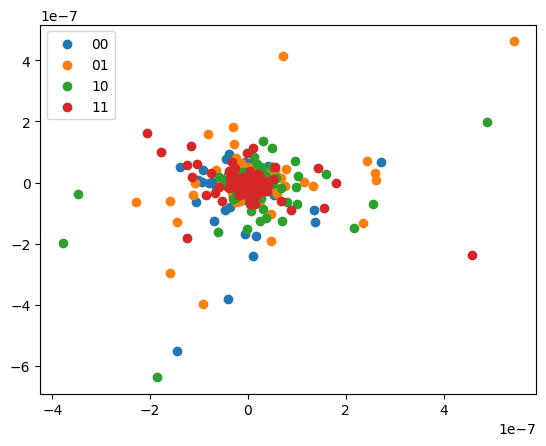

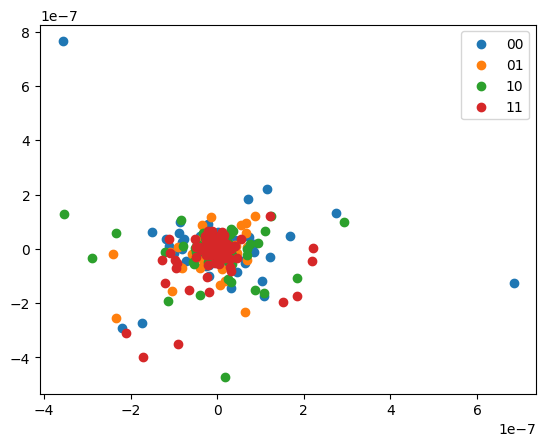

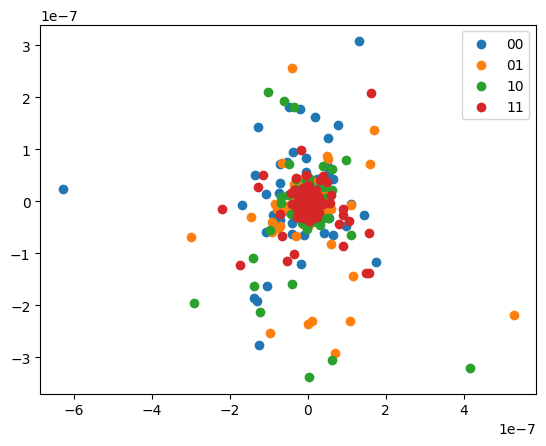

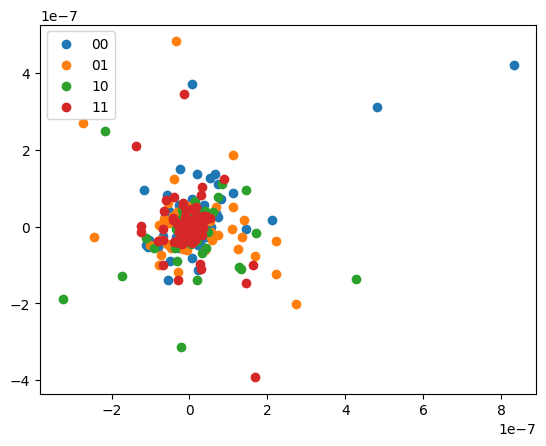

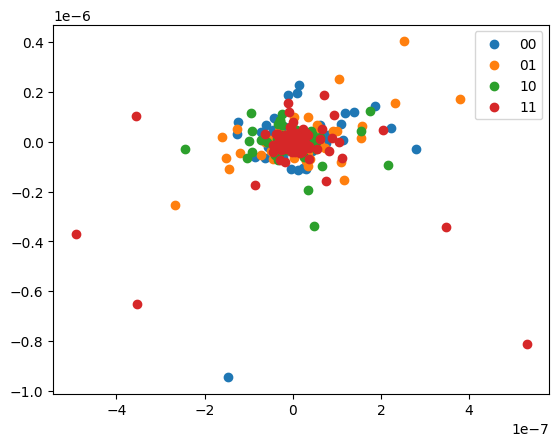

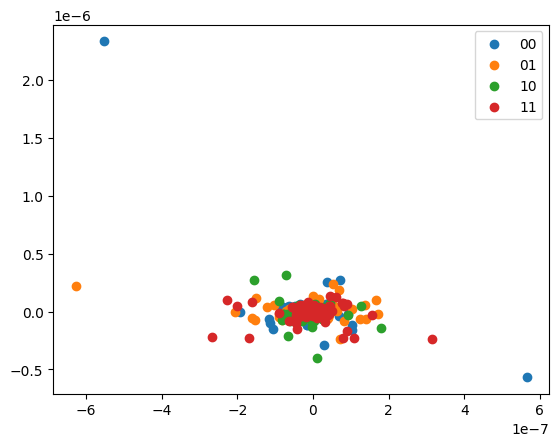

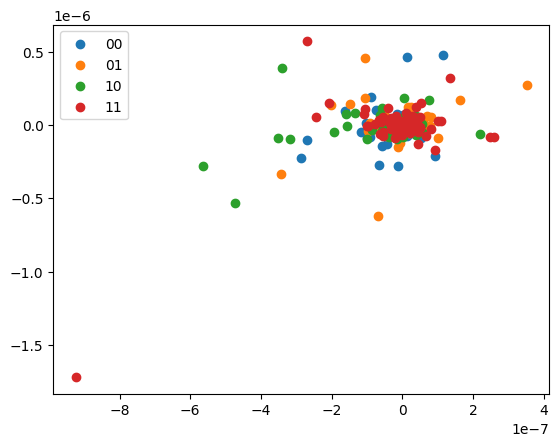

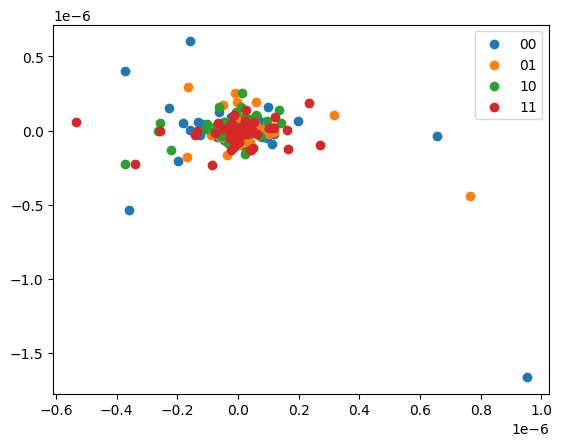

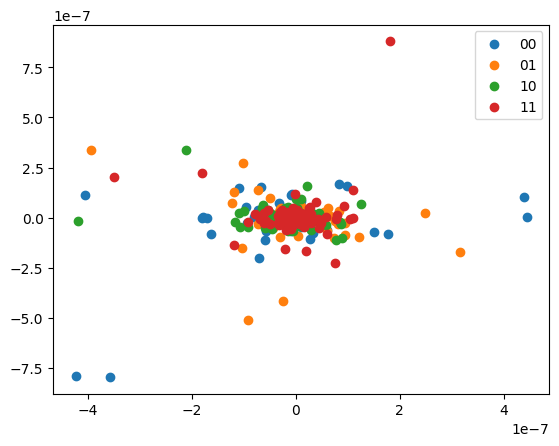

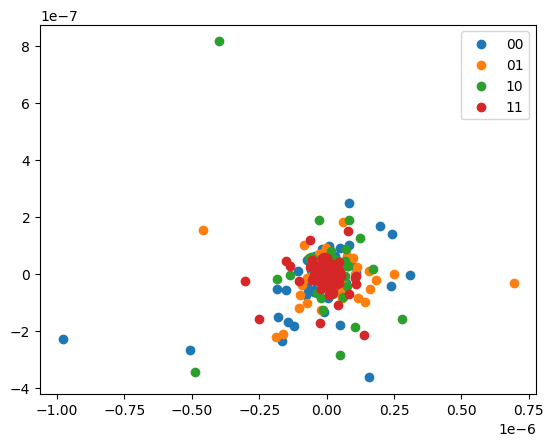

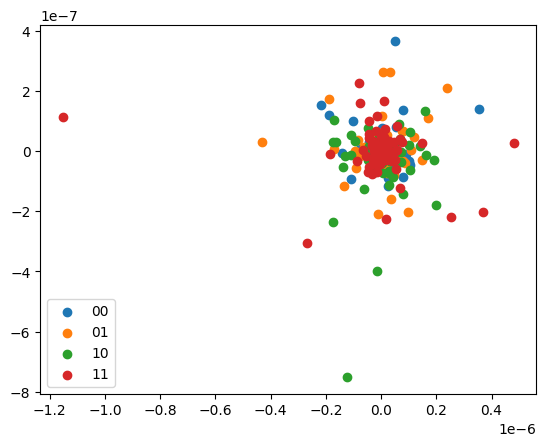

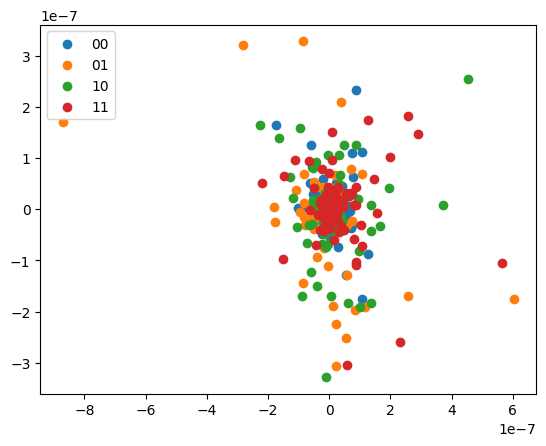

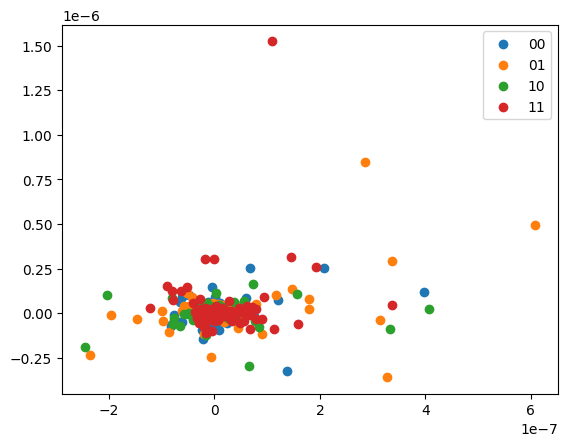

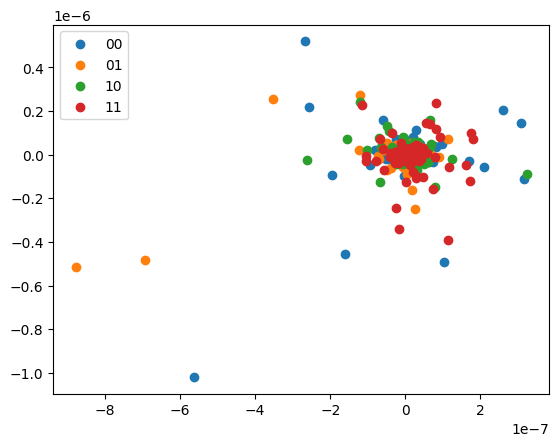

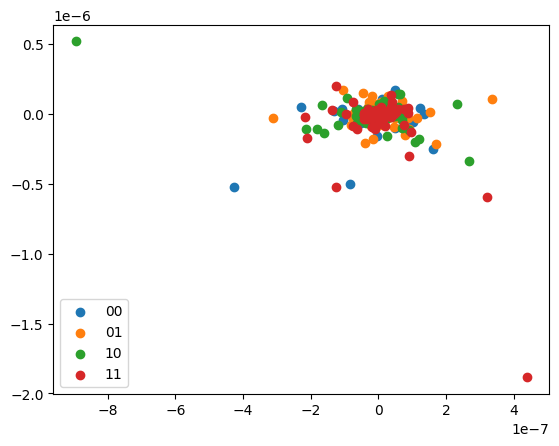

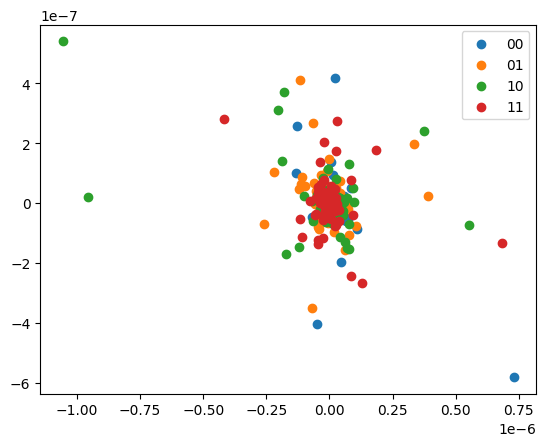

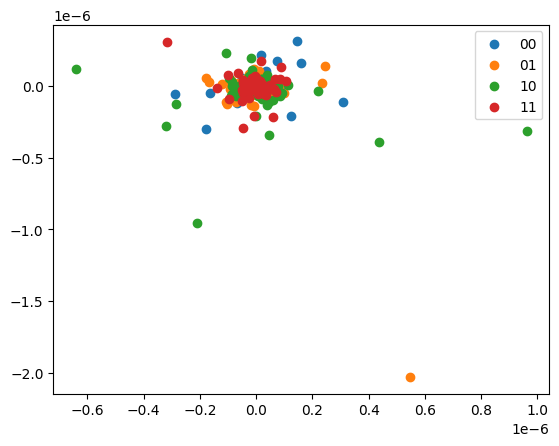

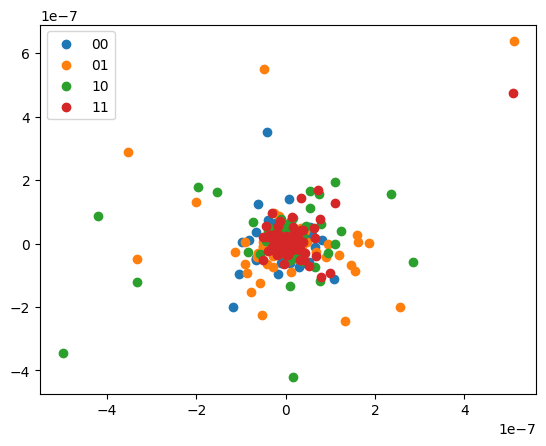

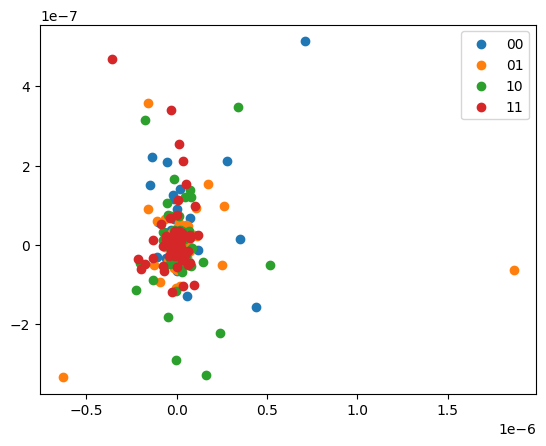

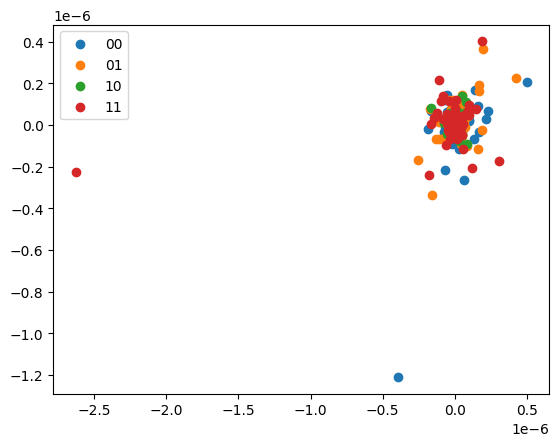

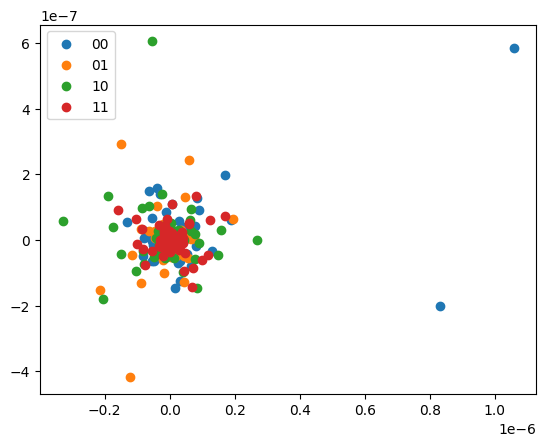

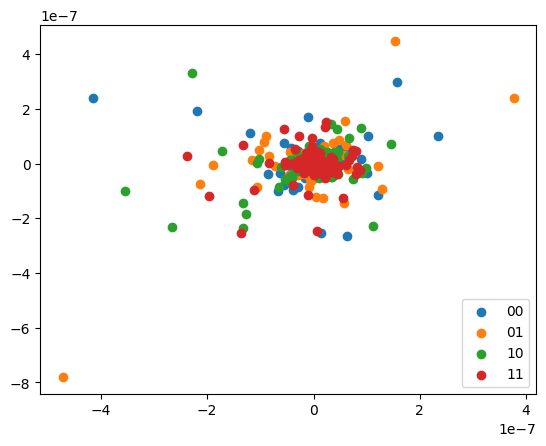

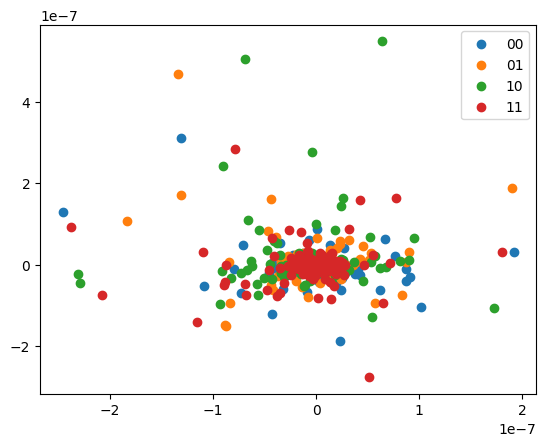

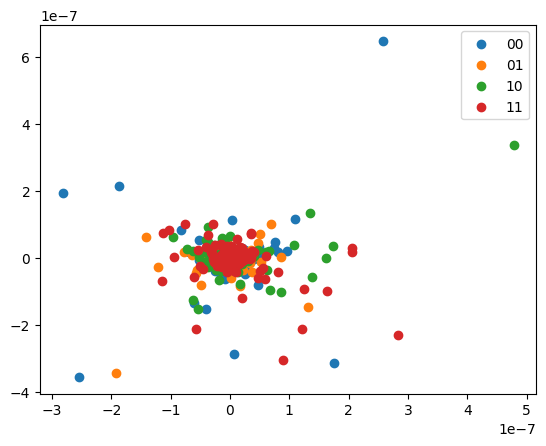

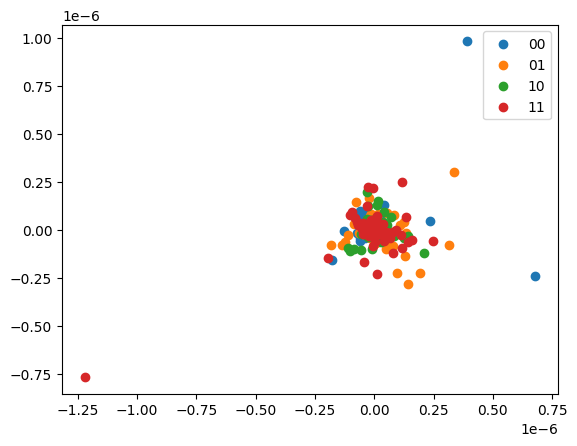

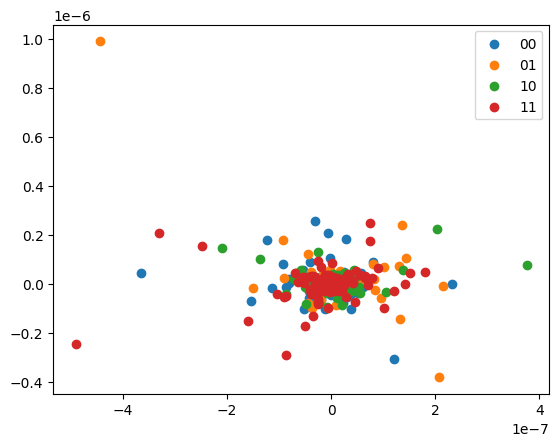

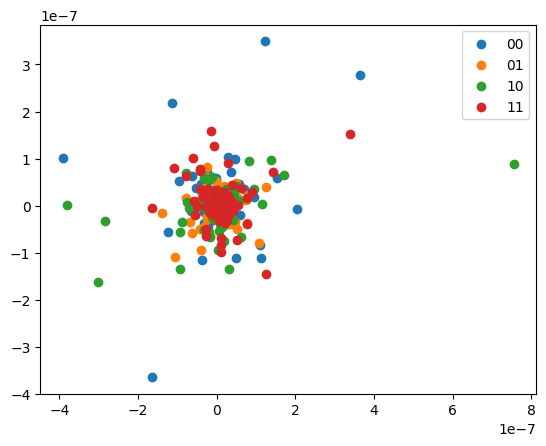

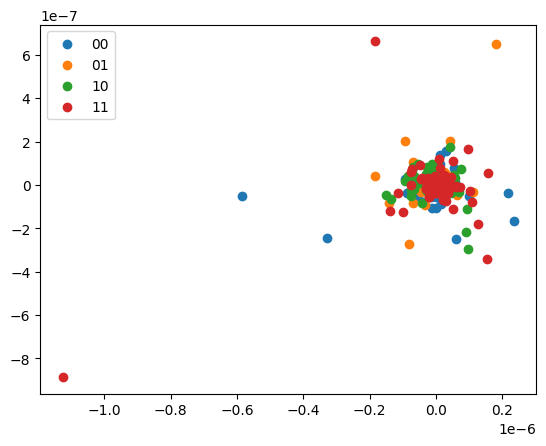

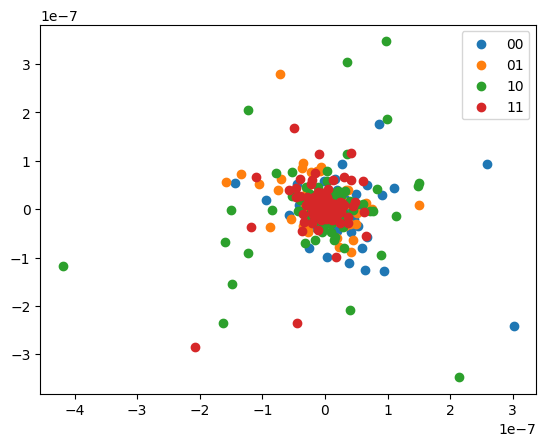

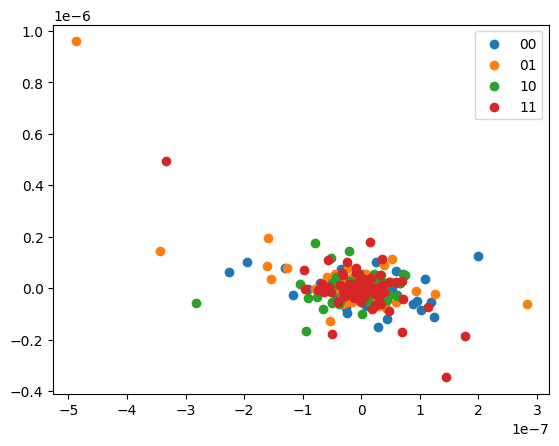

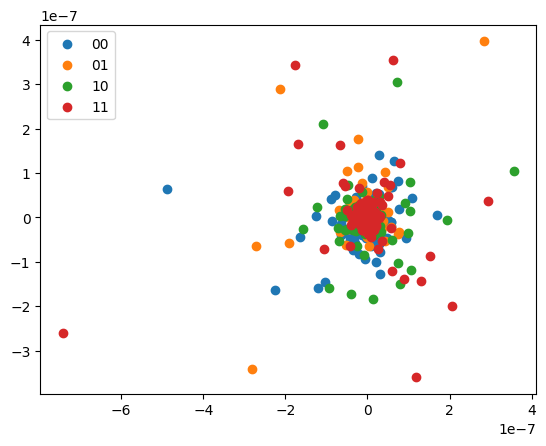

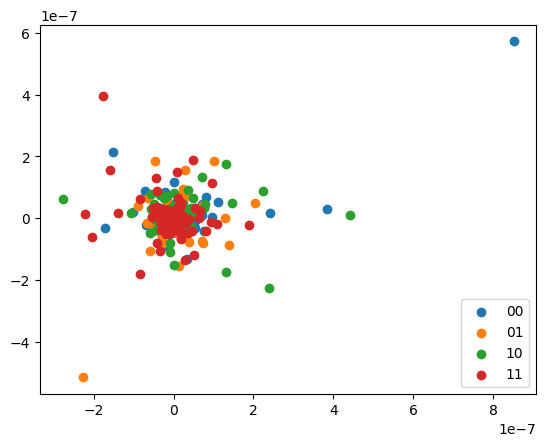

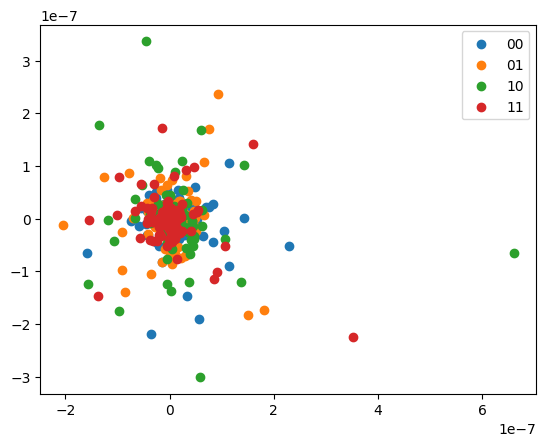

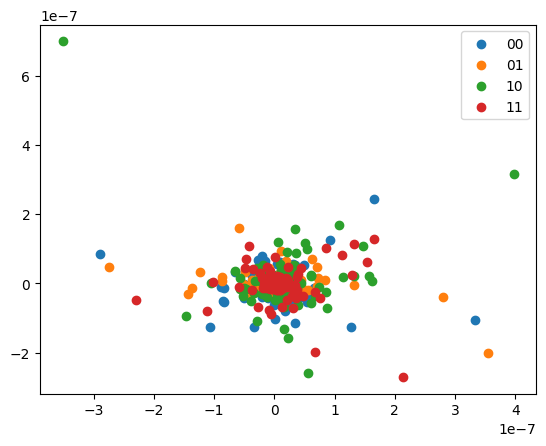

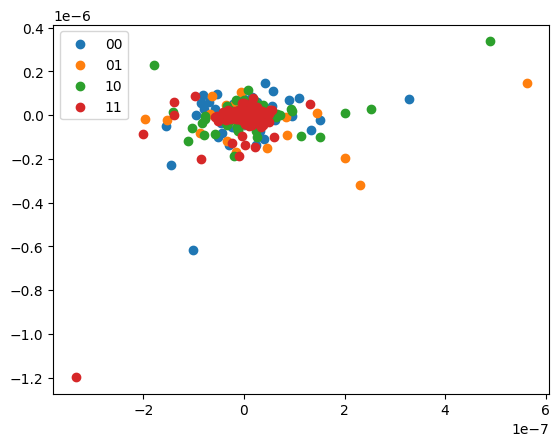

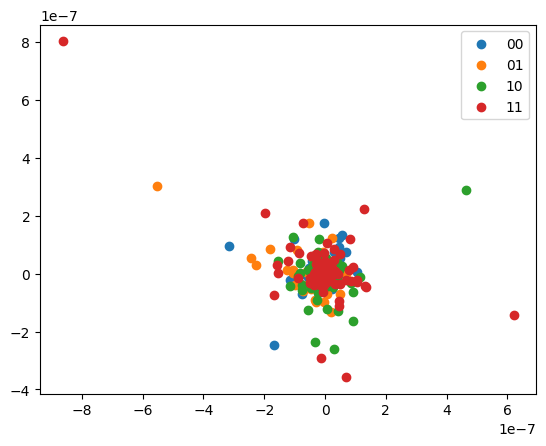

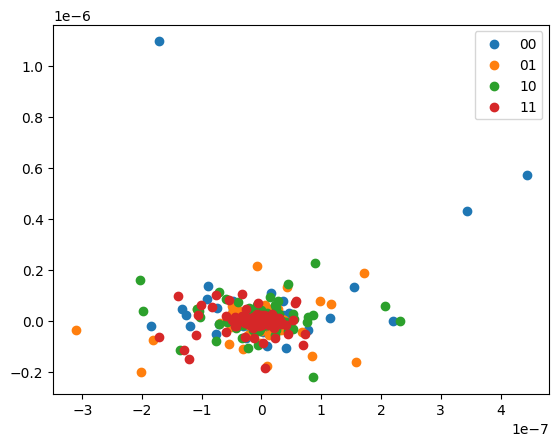

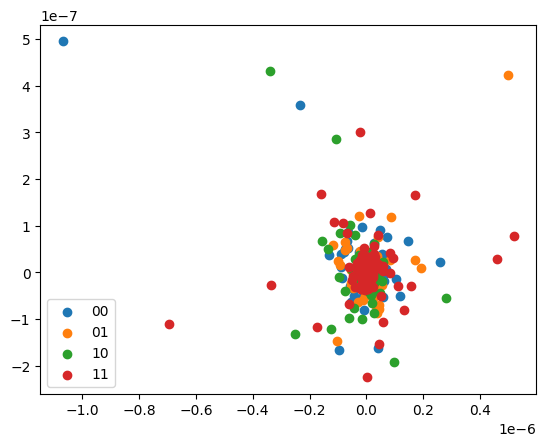

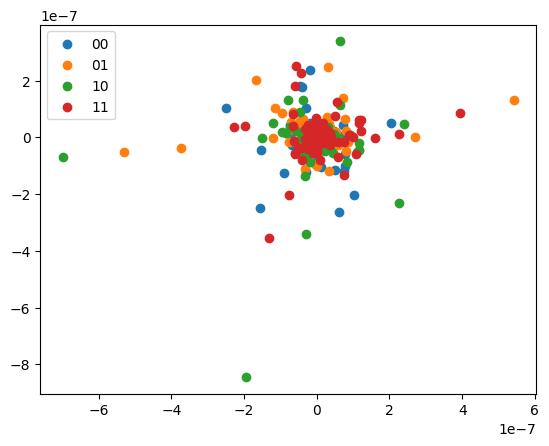

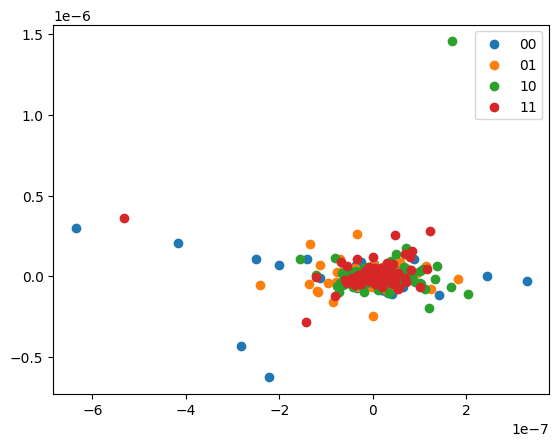

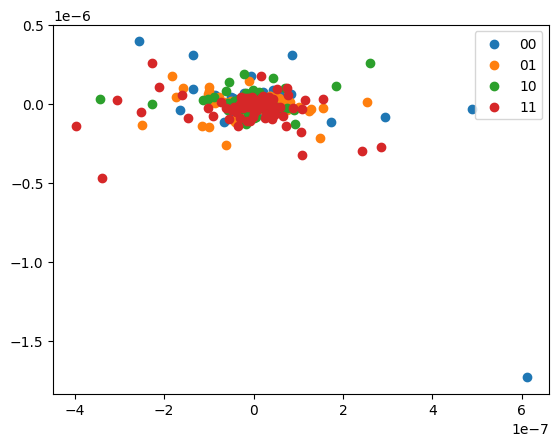

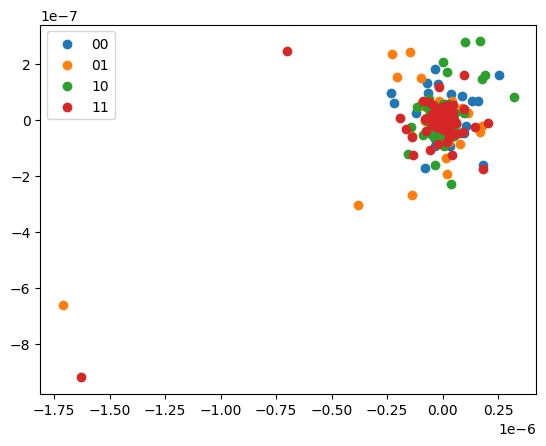

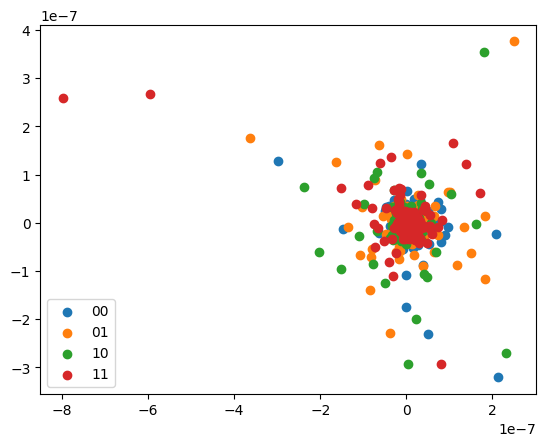

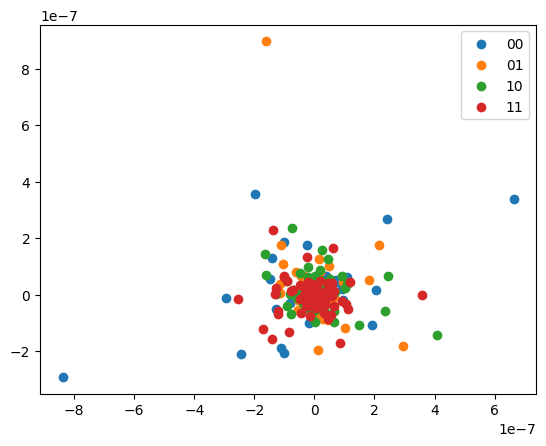

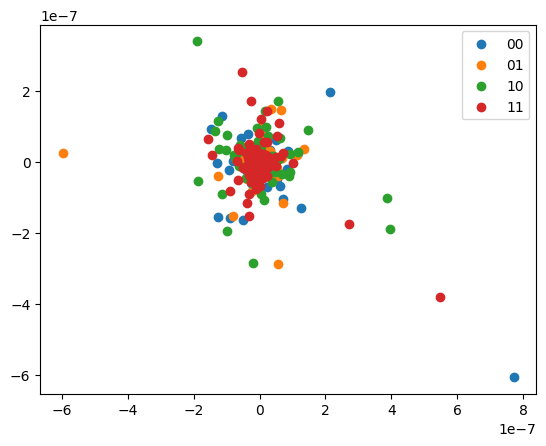

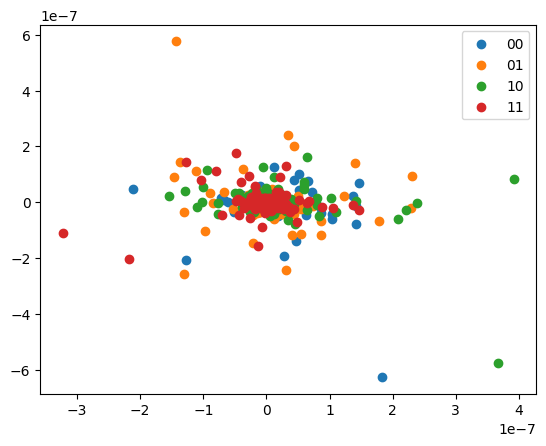

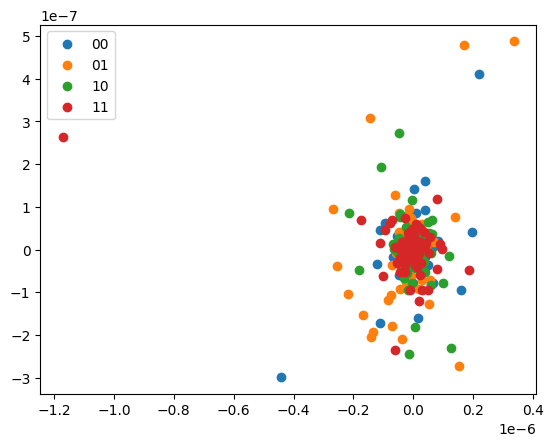

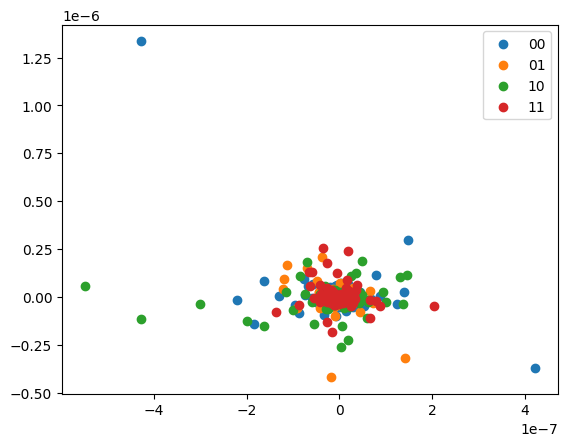

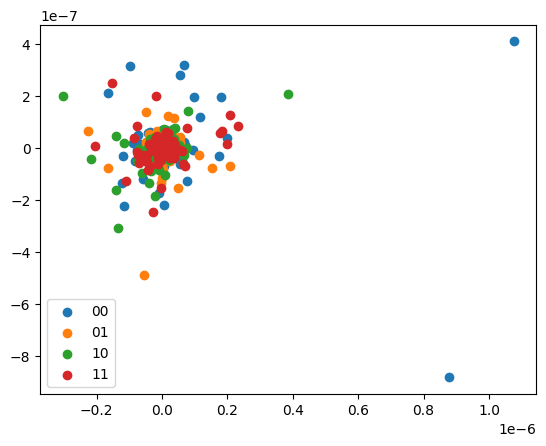

In [ ]:
for i in range(RECIEVED_DATA_BLOCKS):
    # Create boolean masks to color received symbols based on what the transmitted symbol was
    positive_real_mask = np.real(data_qpsk_values[i]) > 0
    positive_imag_mask = np.imag(data_qpsk_values[i]) > 0
    mask_00 = positive_real_mask & positive_imag_mask #& high_freq_mask
    mask_01 = (~positive_real_mask) & positive_imag_mask #& high_freq_mask
    mask_11 = (~positive_real_mask) & (~positive_imag_mask) #& high_freq_mask
    mask_10 = positive_real_mask & (~positive_imag_mask) #& high_freq_mask

    # Plot received symbols
    fig, ax = plt.subplots()
    for mask, bits in ((mask_00, "00"), (mask_01, "01"), (mask_10, "10"), (mask_11, "11")):
        ax.scatter(np.real(recv_qpsk_symbols[i][mask]), np.imag(recv_qpsk_symbols[i][mask]), label=bits)

    # ax_limit = 1
    # ax.set_xlim(-ax_limit, ax_limit)
    # ax.set_ylim(-ax_limit, ax_limit)
    ax.legend()